# Combination of Smaplers and Classifiers:
The goal of this program is to present the confusion matrix of **all possible combinations between samplers and classifiers of choice**, to help the **astronomer decide** which one will serve their purposes better.

The program uses the selected sampler to balance a training dataset for the classifier, and then tests the classifier either with a balanced testing dataset or with an inbalanced one. A reduced dataset is also used to test the effects of reducing the atributes of each object in the accuracy of the classifier.

**The results confirm our estimates from the data visualization section:** the only usable results come from using **random undersampling** to balance the dataset, and **there is no major difference between using eight atributes and a label to define objects and using only the three  atributes selected through a heat map** in that section.

The results also prove that classifiers trained on unbalanced methods reported unreliable results.

In [1]:
# Standard library
from statistics import mean, stdev

# Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: preprocessing and model selection
from sklearn import preprocessing, metrics as mt, svm
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler  # Optional alternative scaler

# Scikit-learn: classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Scikit-learn: evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Imbalanced-learn: under-sampling
from imblearn.under_sampling import (
    TomekLinks,
    AllKNN,
    RandomUnderSampler,
    NeighbourhoodCleaningRule
)

In [2]:
%run Aux_Methods.ipynb

## Original Dataset

In [3]:
df_0 = pd.read_csv("../data/HTRU_2.csv")
keys = df_0.keys()
class_key = keys[len(keys) - 1]

df_0 = prepare_data(df_0, autobalance=False)

The final dataset contains 17898 samples


In [4]:
df_0.head()

,Mean_IP,Standard_Dev_IP,E_Kurtosis_IP,Skewness_IP,Mean_SNR,Standard_Dev_SNR,E_Kurtosis_SNR,Skewness_SNR,Class
0,0.721342,0.417687,0.165043,0.015627,0.013382,0.113681,0.294986,0.063890,0.0
1,0.517628,0.460908,0.235415,0.018268,0.006560,0.072524,0.364015,0.108443,0.0
2,0.520346,0.196868,0.221138,0.040677,0.013030,0.139188,0.288624,0.054610,0.0
3,0.700933,0.437884,0.181750,0.016534,0.015368,0.131583,0.266348,0.046581,0.0
4,0.443854,0.214847,0.249044,0.041712,0.004327,0.039684,0.462029,0.213369,0.0


## Reduced Dataset

In this dataset, we drop all the atributes that we suspect are unnecesary from our studies in the data visualization, in order to compare the results obtained with this dataset as opposed to those from the original dataset.

In [5]:
df_c=df_0.copy()

df_c = df_c.drop('Standard_Dev_IP', axis=1)
df_c = df_c.drop('Skewness_IP', axis=1)
df_c = df_c.drop('Mean_SNR', axis=1)
df_c = df_c.drop('E_Kurtosis_SNR', axis=1)
df_c = df_c.drop('Skewness_SNR', axis=1)

In [6]:
df_c.head()

,Mean_IP,E_Kurtosis_IP,Standard_Dev_SNR,Class
0,0.721342,0.165043,0.113681,0.0
1,0.517628,0.235415,0.072524,0.0
2,0.520346,0.221138,0.139188,0.0
3,0.700933,0.181750,0.131583,0.0
4,0.443854,0.249044,0.039684,0.0


## Classifiers to be used

In [7]:
classifiers = [
    KNeighborsClassifier,
    svm.SVC,
    LogisticRegression,
    DecisionTreeClassifier,
]
classifiers_names = [
    "KNeighborsClassifier",
    "svm.SVC",
    "LogisticRegression",
    "DecisionTreeClassifier",
]
parameters = [
    ["n_neighbors", range(3, 10)],
    ["kernel", ["linear", "rbf"]],
    ["random_state", range(6, 16, 3)],
    ["criterion", ["gini", "entropy", "log_loss"]],
]


In [15]:
# Receives arrays of x and y values, and the estimator and indices from a crosvalidation emthod
# Returns the array of all ordered test and predicted labels


def get_y_values(x, y, x_pure_test, y_pure_test, estimators, indices_test):
    cumulative_y_test = np.array([])
    cumulative_y_predict = np.array([])

    for estimator, test_indices in zip(estimators, indices_test):
        x_test = np.take(x, test_indices, axis=0)
        y_test = np.take(y, test_indices, axis=0)

        if (x_pure_test is not None) and (y_pure_test is not None):
            x_test = np.concatenate((x_test, x_pure_test), axis=0)
            y_test = np.concatenate((y_test, y_pure_test), axis=0)

        cumulative_y_test = np.concatenate([cumulative_y_test, y_test], 0)
        y_pred = estimator.predict(x_test)
        cumulative_y_predict = np.concatenate([cumulative_y_predict, y_pred], 0)

    return cumulative_y_test, cumulative_y_predict


# Accepts the original dataframe, the balanced dataframe, and a classifier as parameters
# Runs the classifier with crossvalidation
# Returns the array of test labls and predicted labels obtained through crossvalidation


def run_cross(df, df_bal, classifier):
    class_key = df_bal.columns[-1]

    if df is not None:
        df_pure_test = pd.concat([df.copy(), df_bal.copy()])
        df_pure_test.drop_duplicates(subset=None, keep=False, inplace=True)
        y_pure_test = df_pure_test[class_key].to_numpy()
        x_pure_test = df_pure_test.drop(class_key, axis=1).to_numpy()
    else:
        x_pure_test, y_pure_test = None, None

    y = df_bal[class_key].to_numpy()
    x = df_bal.drop(class_key, axis=1).to_numpy()

    crossed_results = cross_validate(
        classifier,
        x,
        y,
        cv=4,
        return_train_score=True,
        return_estimator=True,
        return_indices=True,
    )
    y_test, y_predict = get_y_values(
        x,
        y,
        x_pure_test,
        y_pure_test,
        crossed_results["estimator"],
        crossed_results["indices"]["test"],
    )

    return y_test, y_predict


# Receives a reduced dataframe, a classifier cosntruction and other classifier parameters
# may receive the original dataframe
# For each given parameter for the classifier, Runs crossvalidation on the classifier
# Displays a figure with the confussion matrix for all parameters


def run_and_display_classifier(df_bal, classifier_cons, classifier_name, parameter, df):
    results_dict = {}
    kw = parameter[0]
    f, axes = plt.subplots(1, len(parameter[1]), figsize=(20, 5), sharey="row")

    for p, i in zip(parameter[1], range(len(parameter[1]))):
        kwargs = {kw: p}
        classifier = classifier_cons(**kwargs)

        y_test, y_predict = run_cross(df, df_bal, classifier)

        cf_matrix = confusion_matrix(y_test, y_predict, normalize="all")
        cm = ConfusionMatrixDisplay(
            cf_matrix, display_labels=["false pulsar", "pulsar"]
        )
        cm.plot(ax=axes[i], xticks_rotation=45)
        cm.ax_.set(
            title=f"{classifier_name} for {p}", xlabel="Predicted", ylabel="Actual"
        )
        cm.im_.colorbar.remove()
        cm.ax_.set_xlabel("")

    f.text(0.4, 0.1, "Predicted label", ha="left")
    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    plt.show()
    

In [ ]:
def run_sampler_with_classifier(sampler, unbalanced=False):
    df_bal = df_0.copy()
    df_bal = get_balanced_set_undersampling(sampler, df_bal, class_key).dropna()

    df = df_0.copy() if unbalanced else None

    for classifier_cons, classifier_name, parameter in zip(
        classifiers, classifiers_names, parameters
    ):
        run_and_display_classifier(
            df_bal, classifier_cons, classifier_name, parameter, df
        )


# AllKNN()

### Performance on a Balanced Test Set:

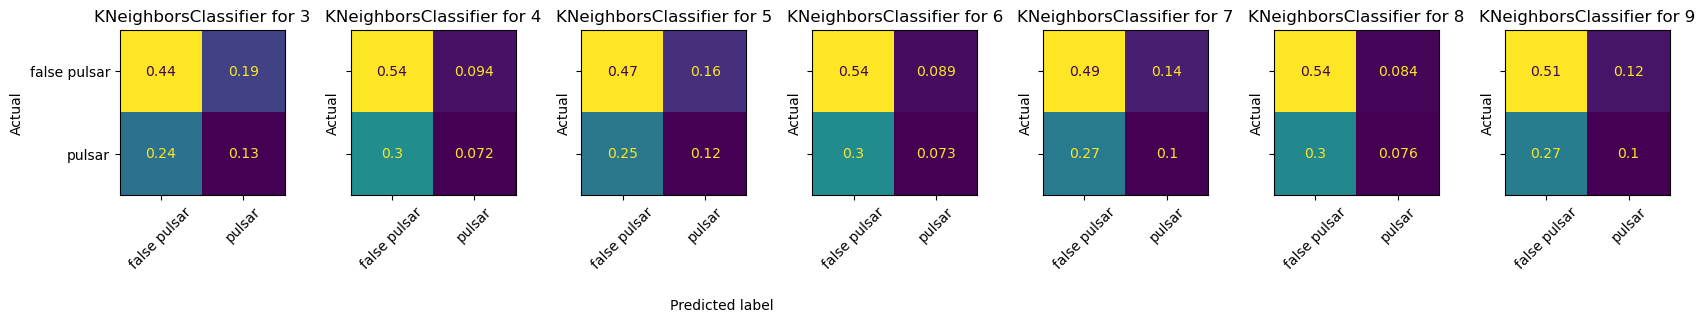

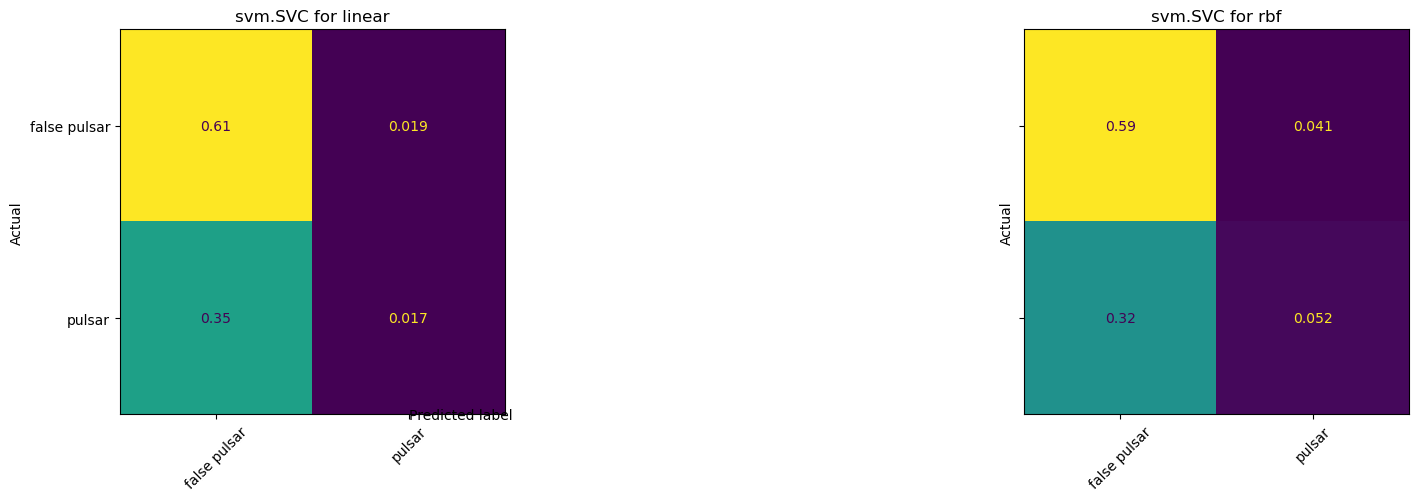

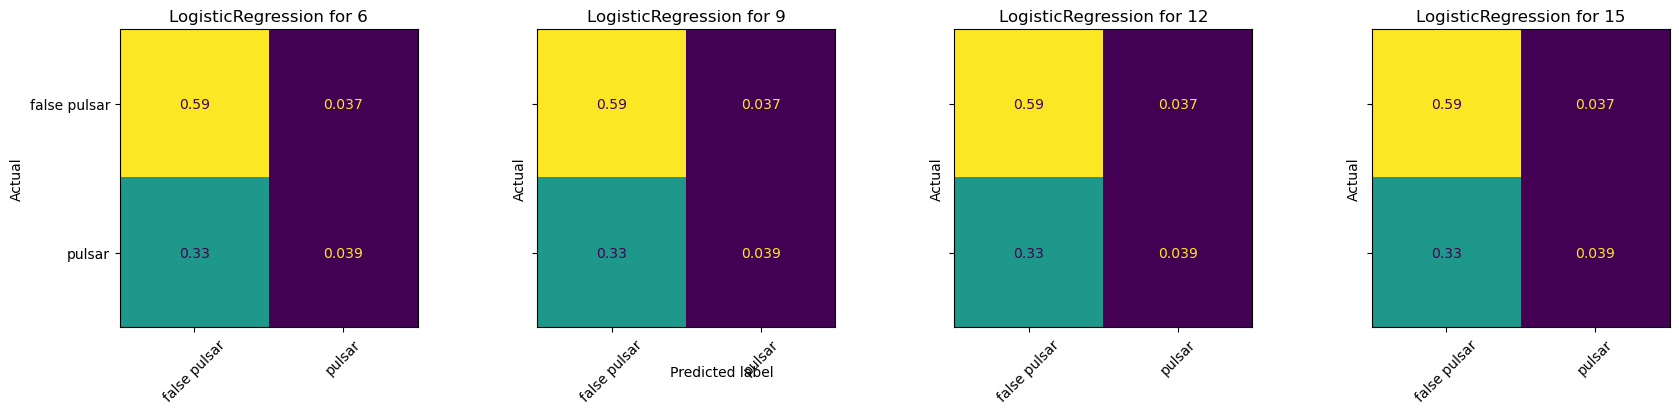

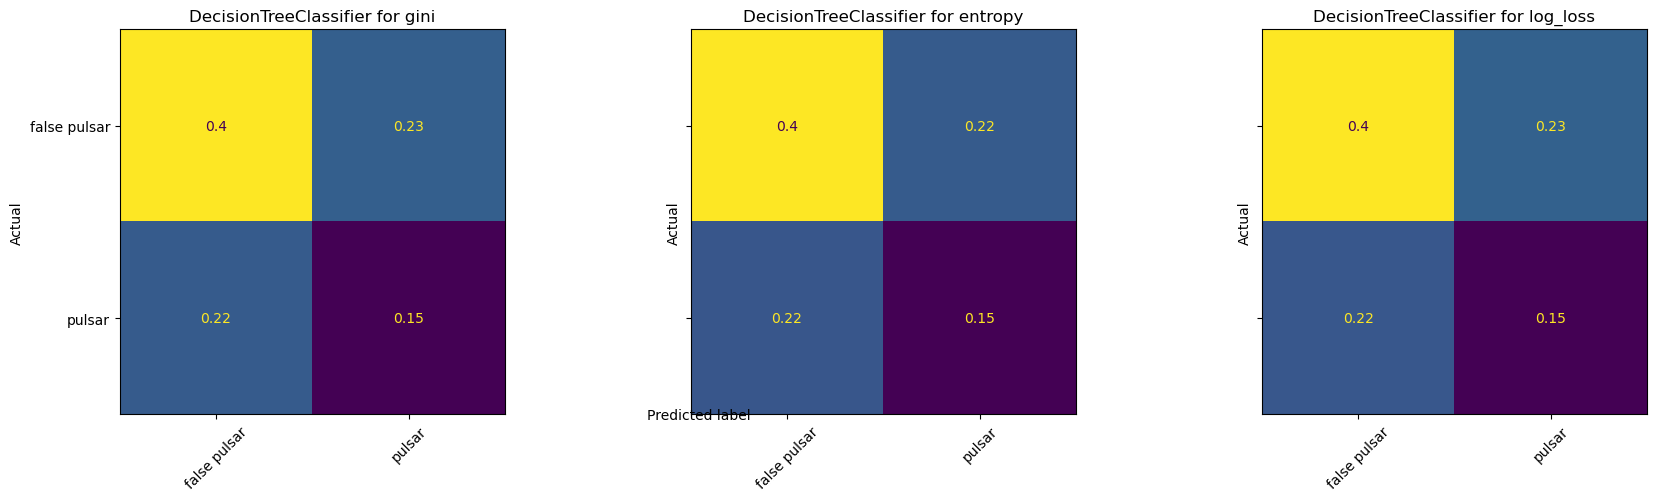

In [16]:
run_sampler_with_classifier(AllKNN(), False)

### Performance on an Unbalanced Test Set:

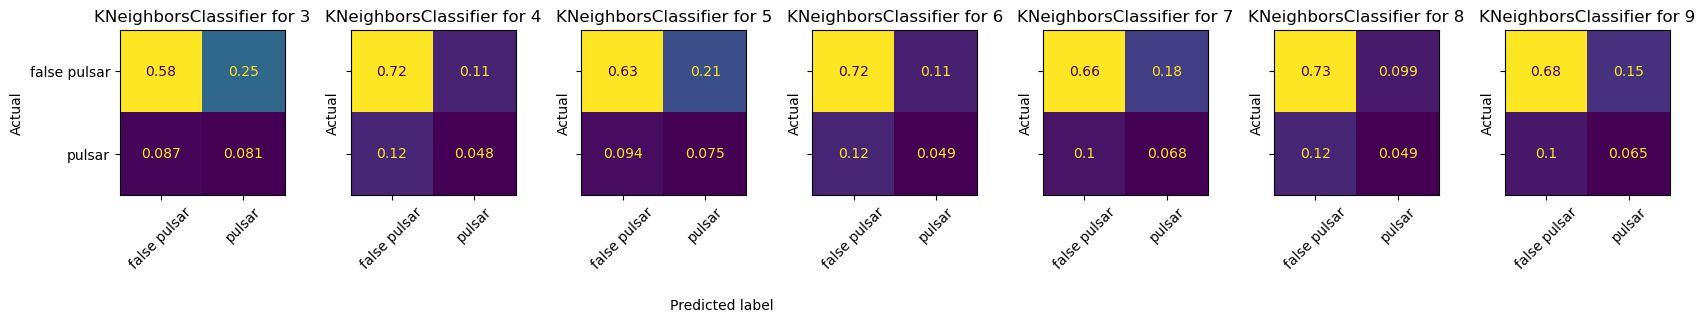

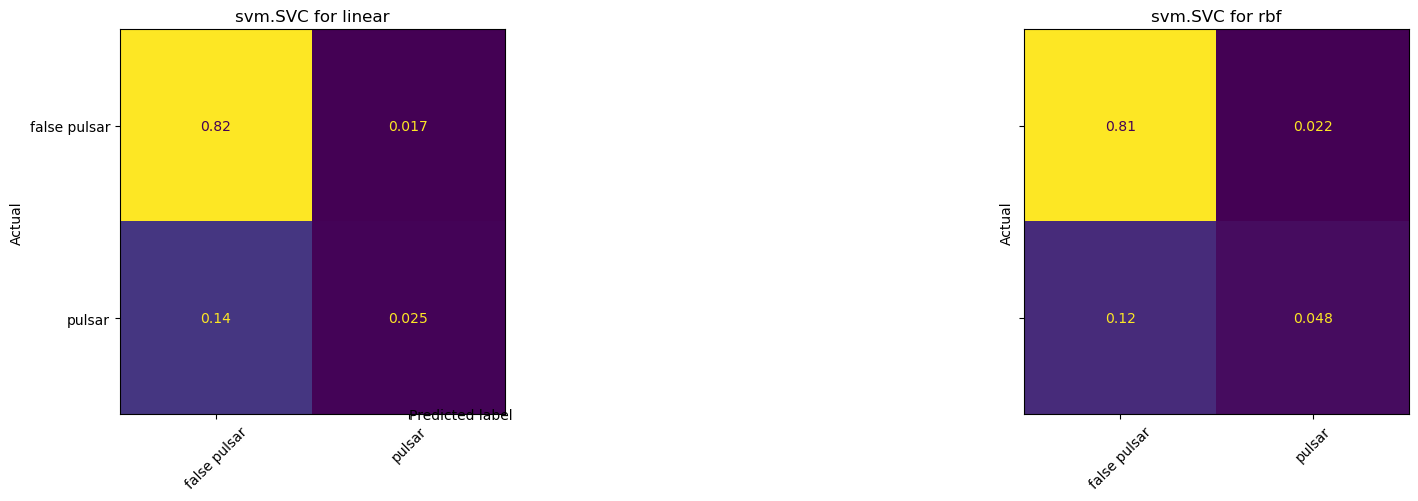

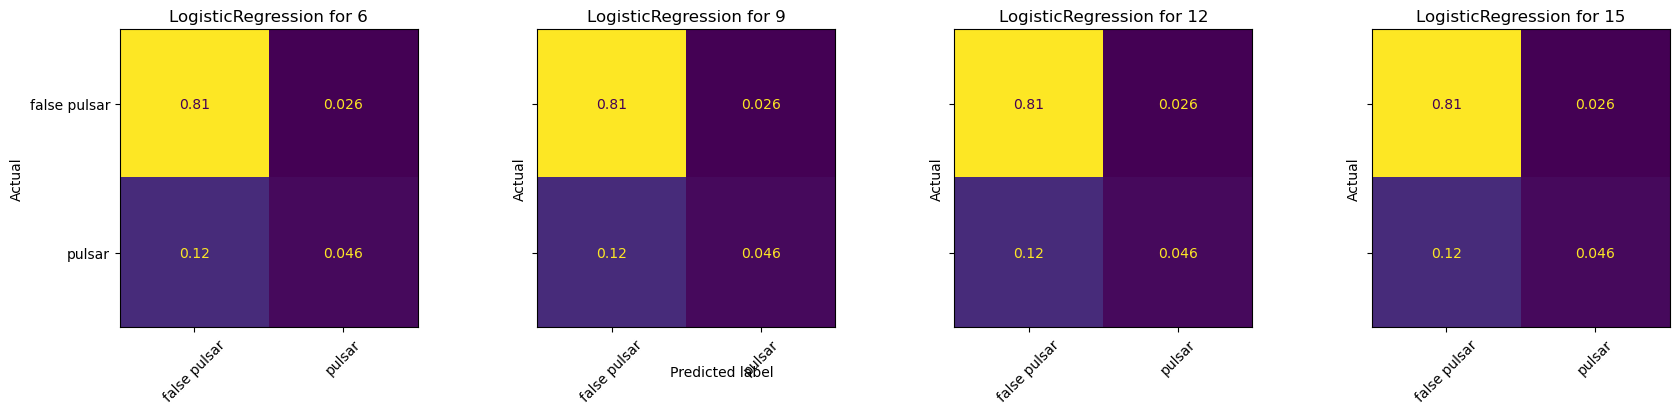

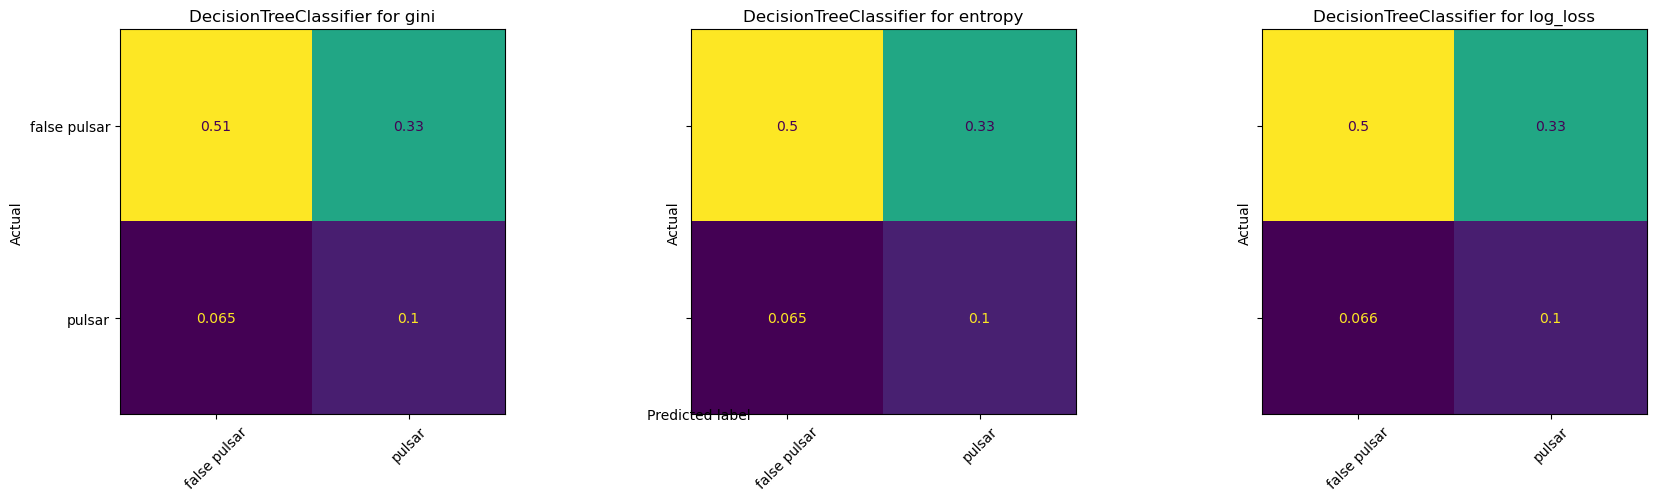

In [14]:
run_sampler_with_clasifier(df_0, AllKNN(), classifiers, classifiers_names, parameters, True)

### Performance with the Reduced Dataset on an Unbalanced Test Set:

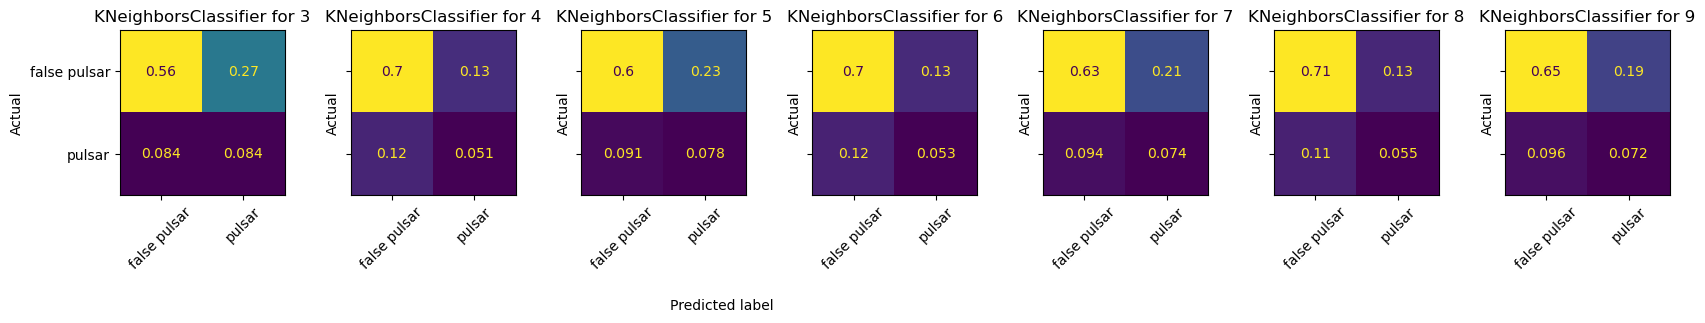

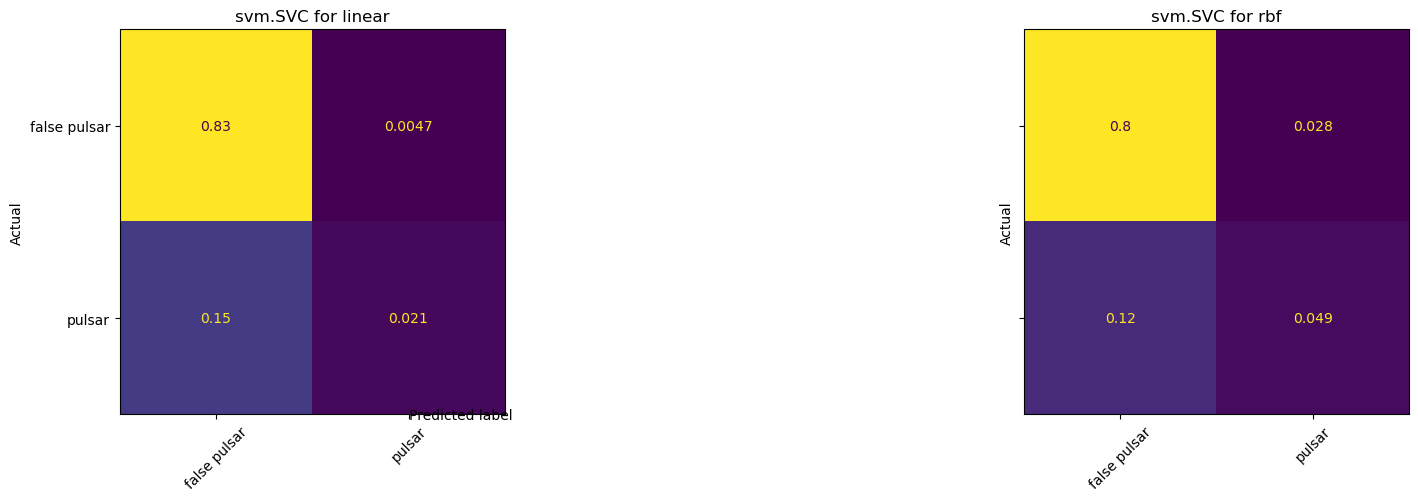

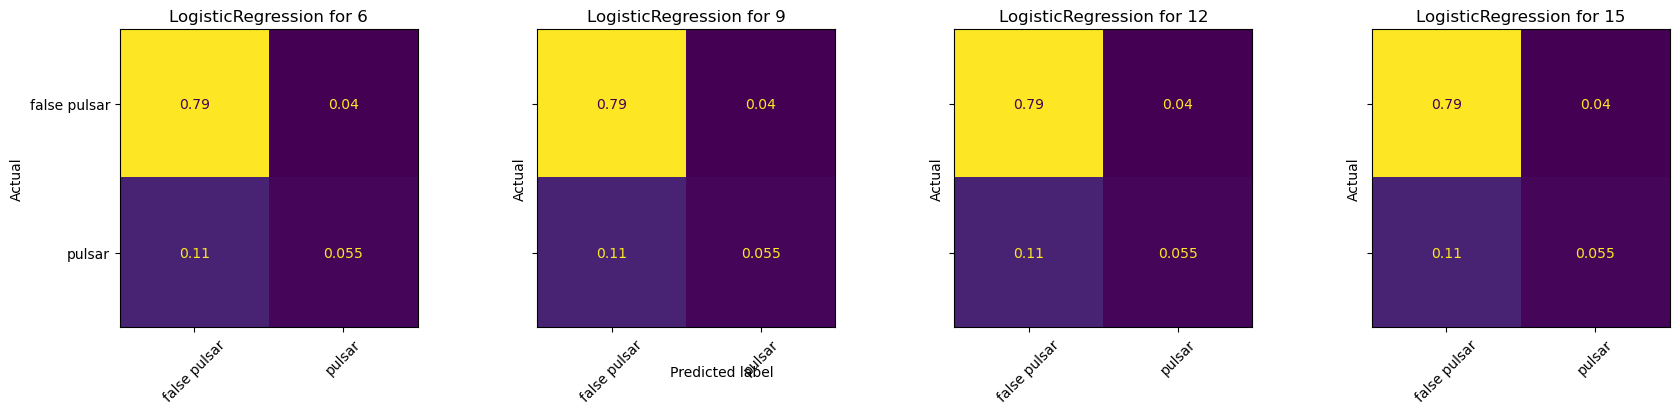

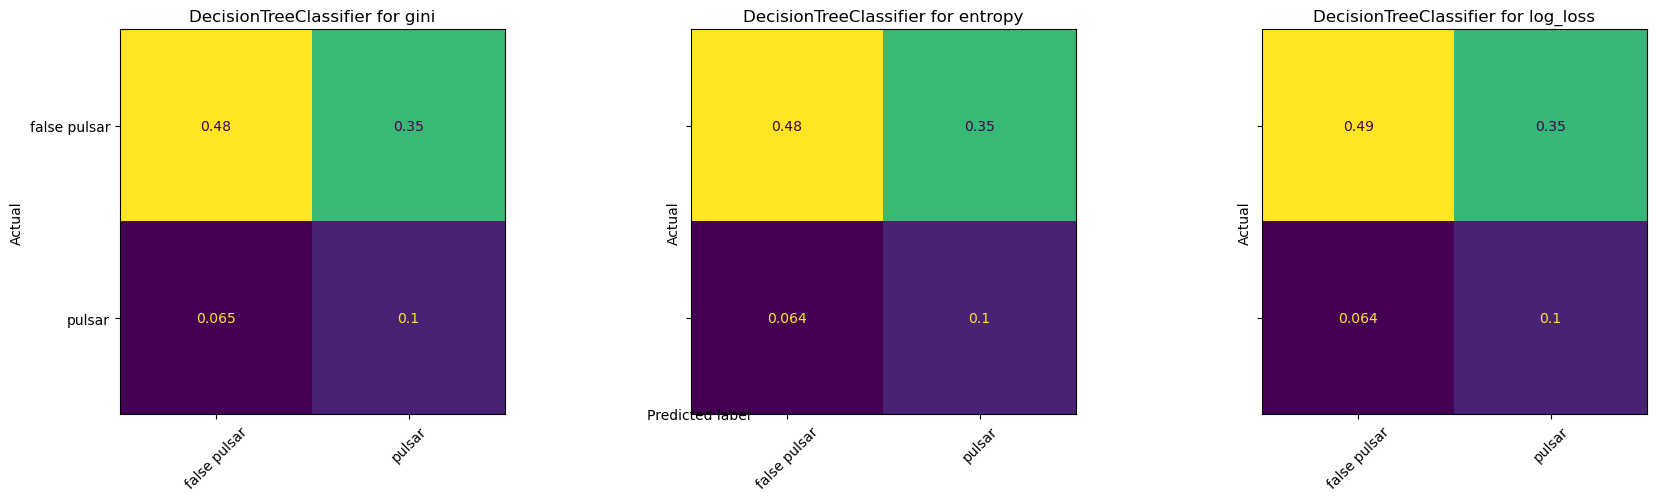

In [15]:
run_sampler_with_clasifier(df_c, AllKNN(), classifiers, classifiers_names, parameters, True)

# TomekLinks()

### Performance on a Balanced Test Set:

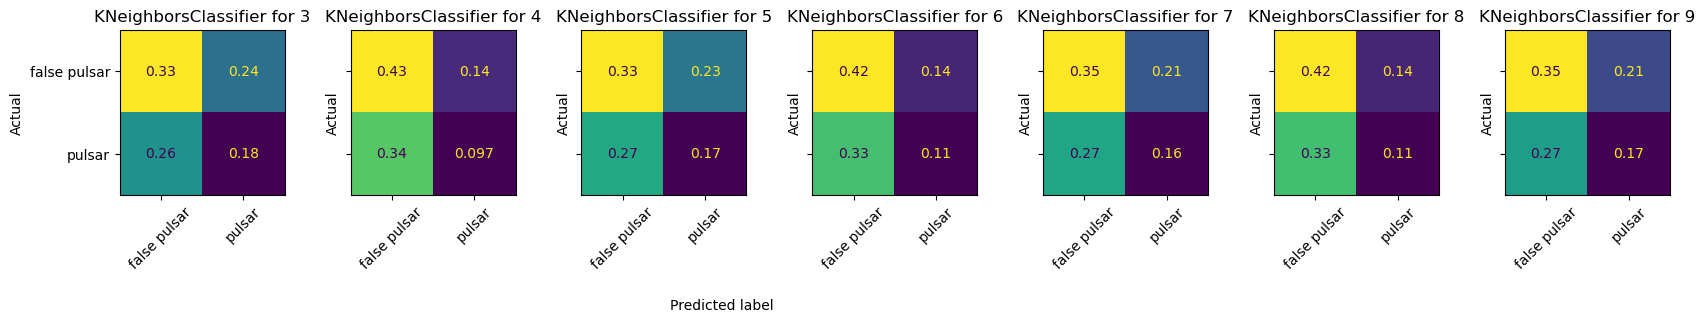

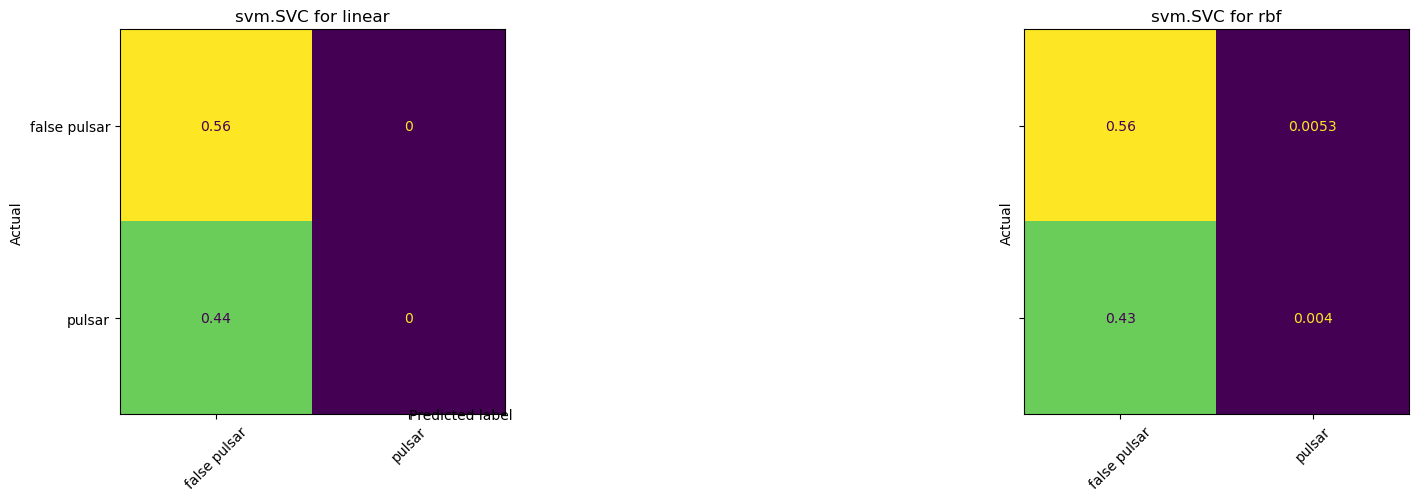

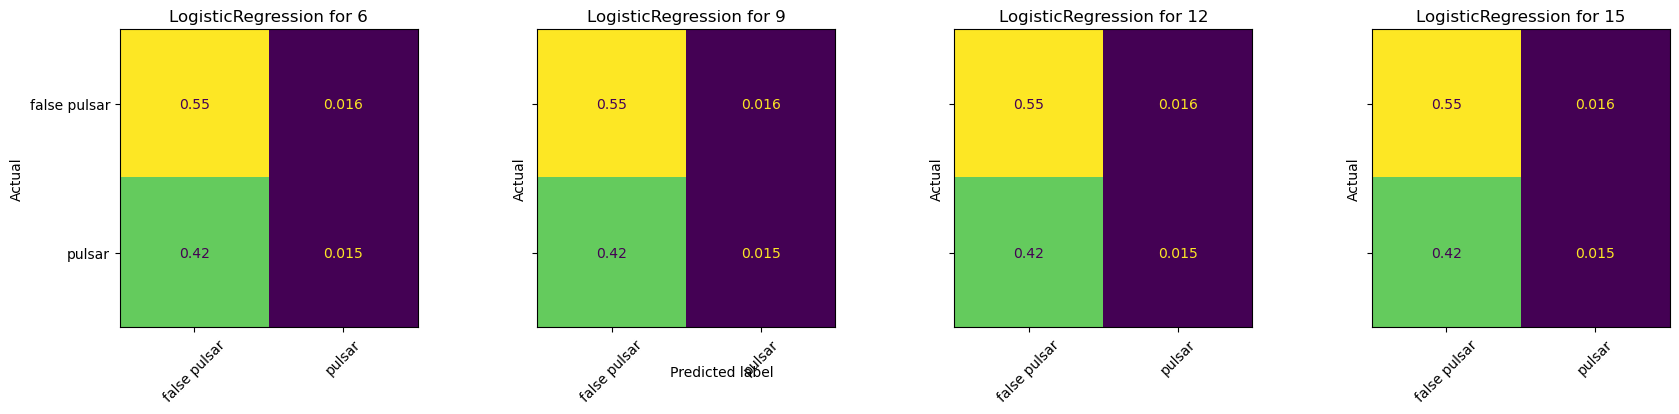

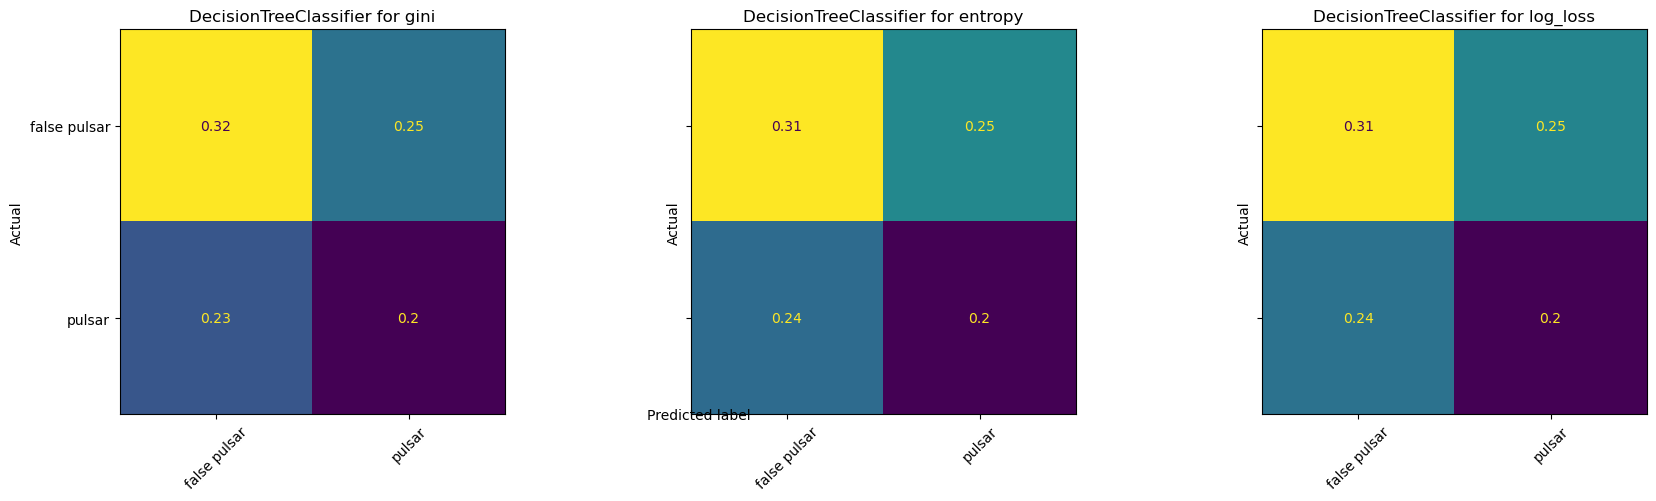

In [16]:
run_sampler_with_clasifier(df_0, TomekLinks(), classifiers, classifiers_names, parameters, False)

### Performance on an Unbalanced Test Set:

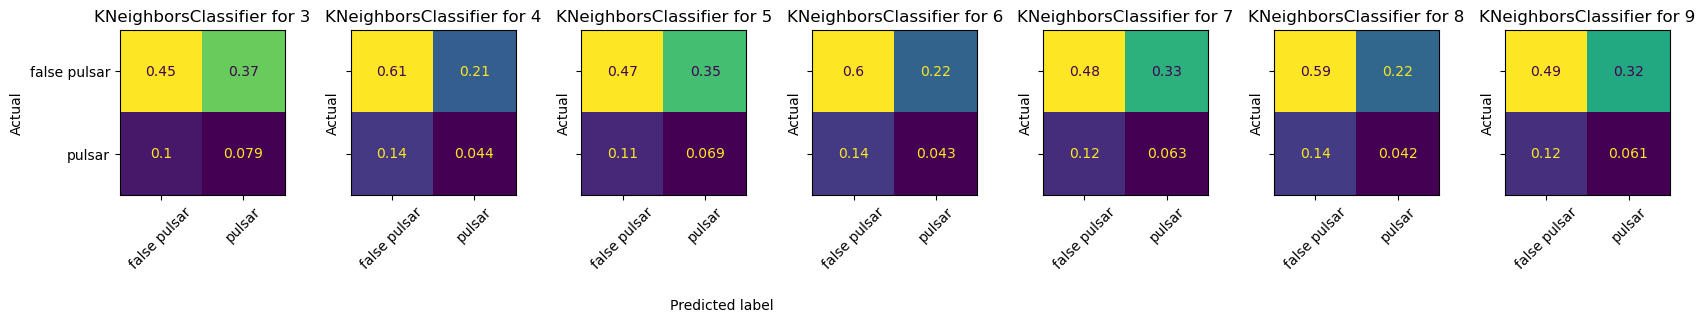

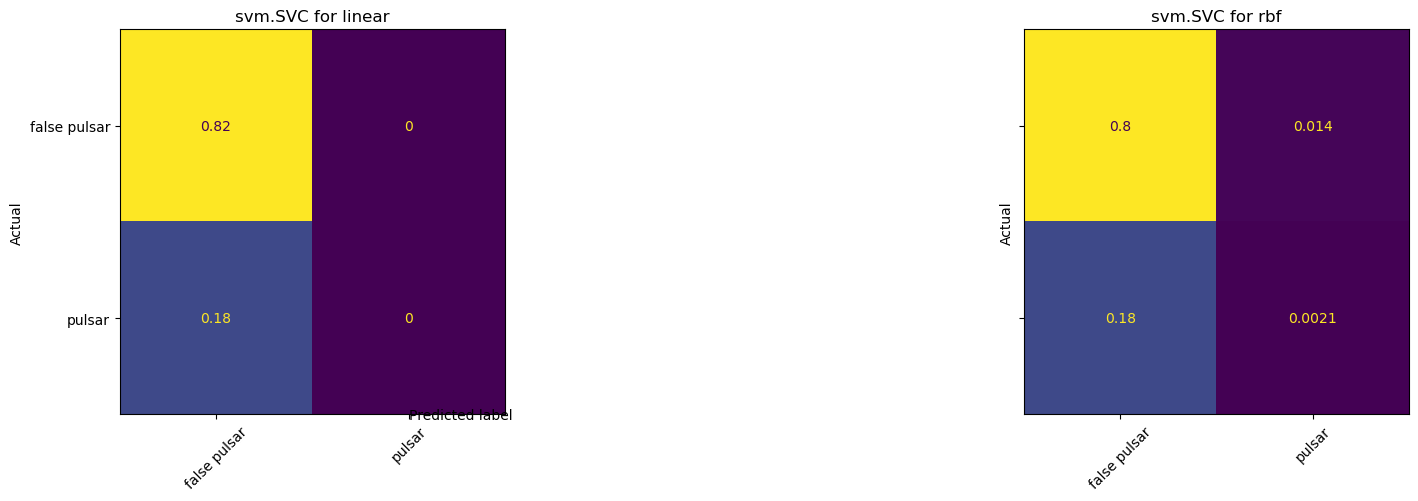

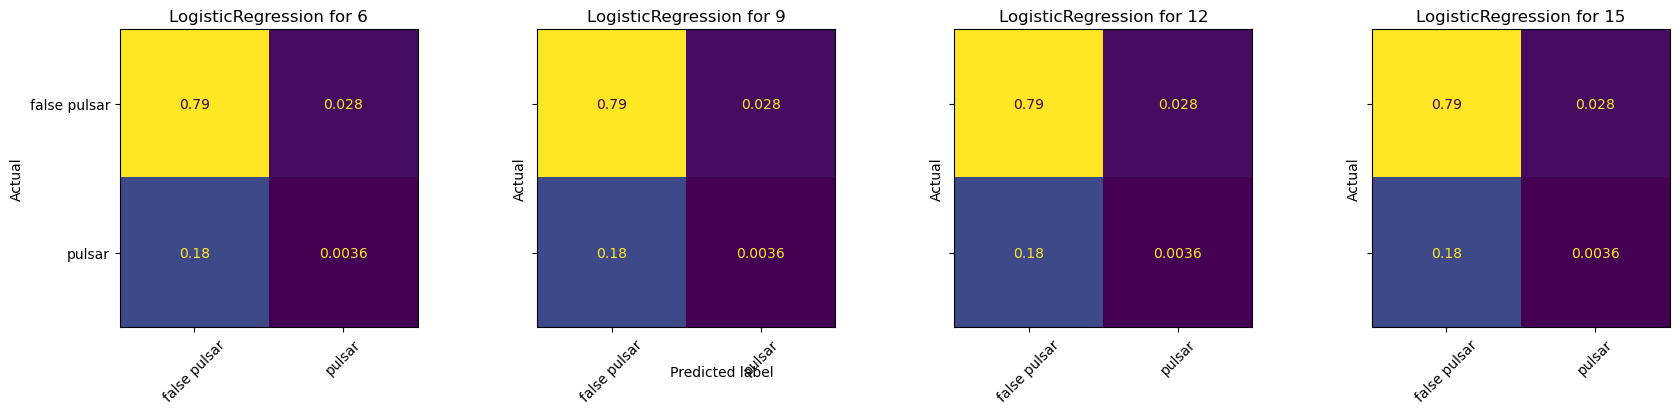

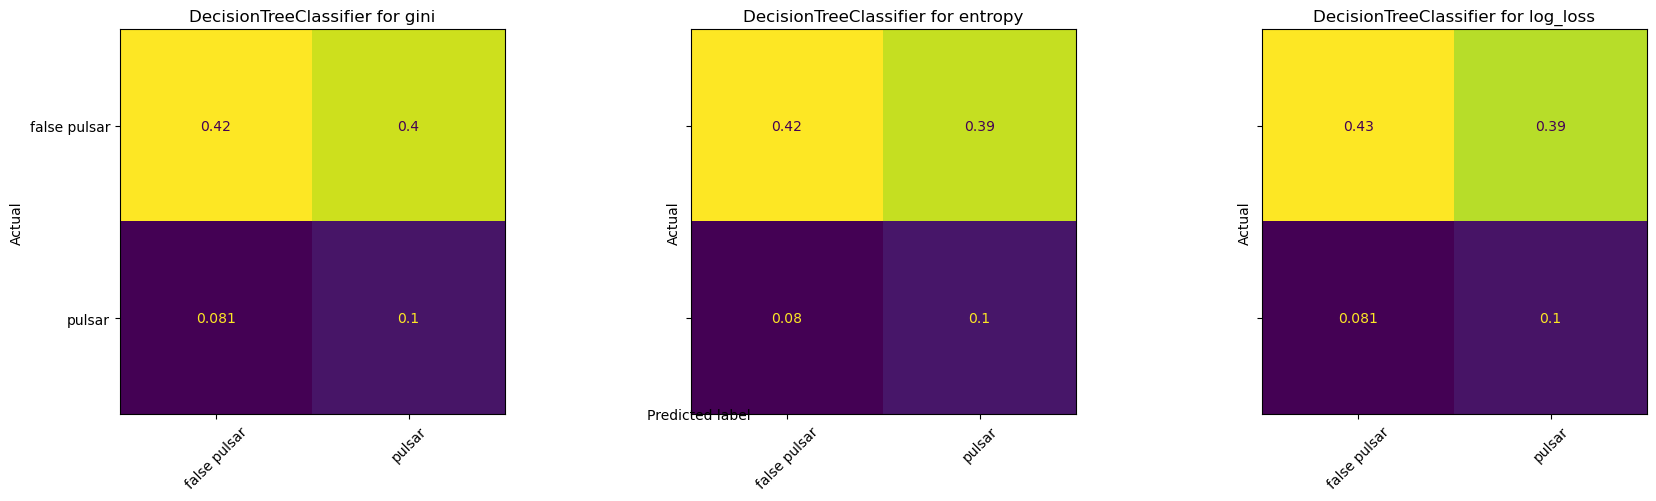

In [17]:
run_sampler_with_clasifier(df_0, TomekLinks(), classifiers, classifiers_names, parameters, True)

### Performance with the Reduced Dataset on an Unbalanced Test Set:

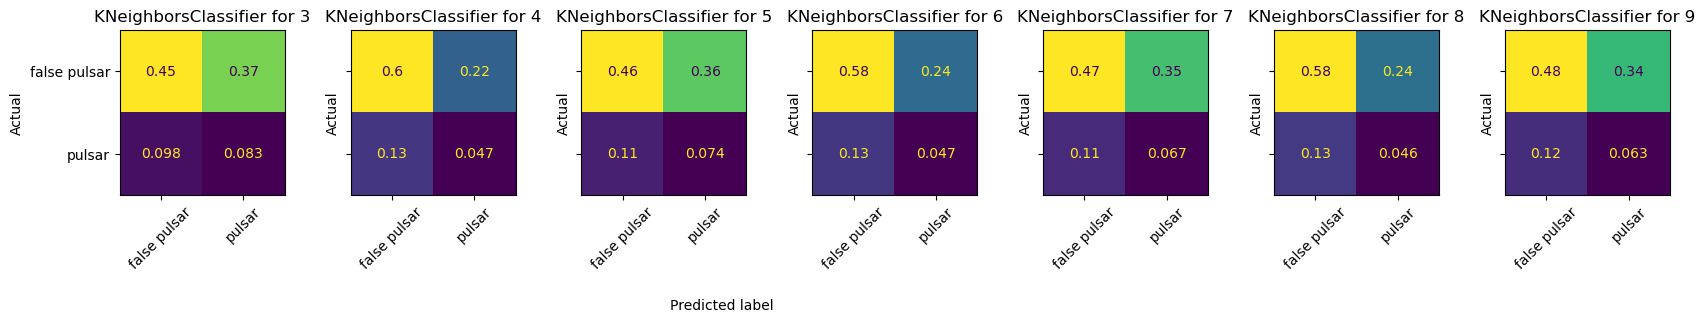

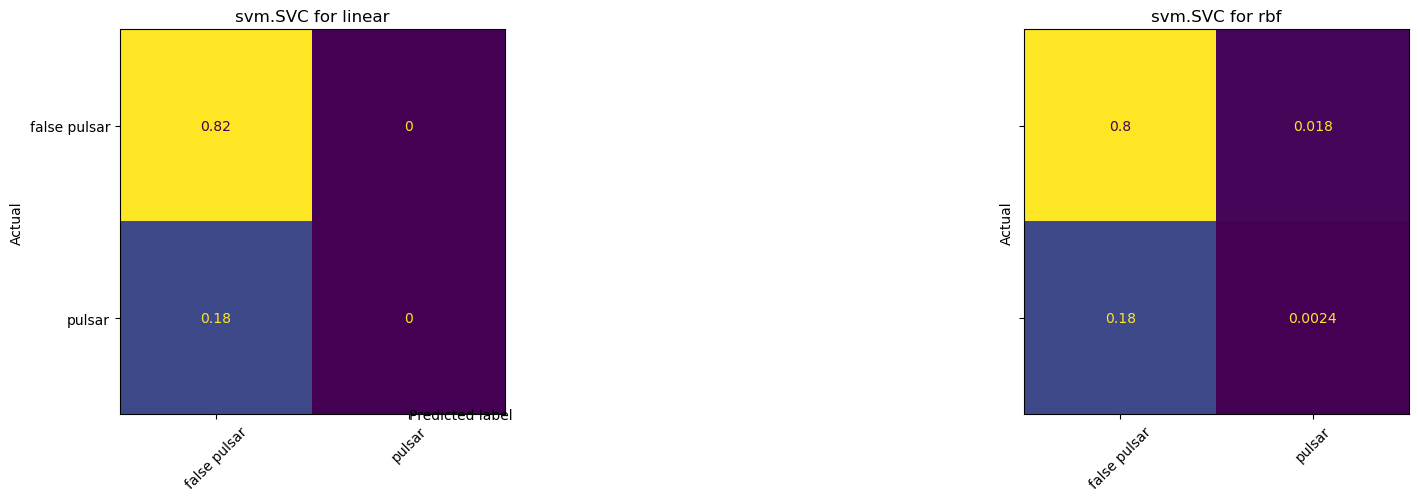

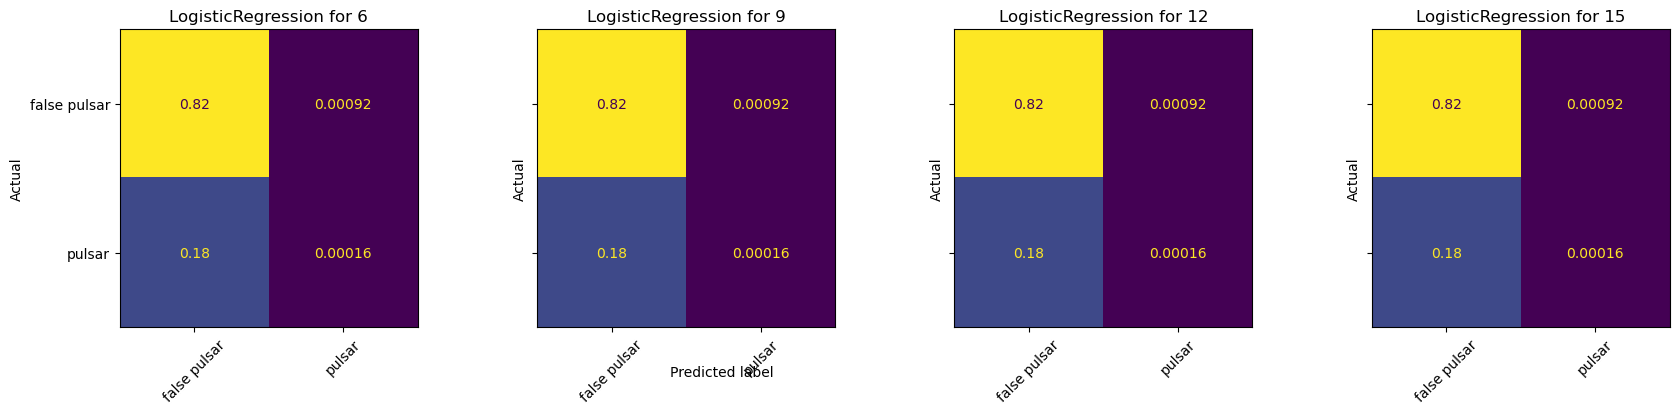

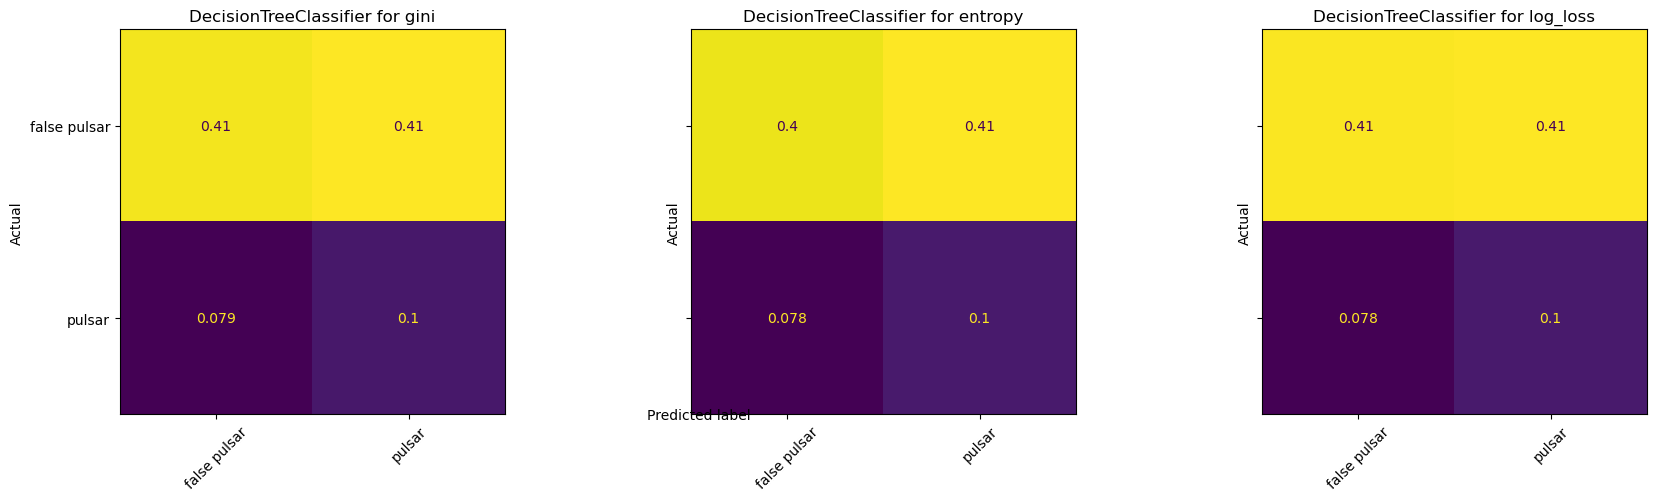

In [18]:
run_sampler_with_clasifier(df_c, TomekLinks(), classifiers, classifiers_names, parameters, True)

# RandomUnderSampler(random_state=0)

### Performance on a Balanced Test Set:

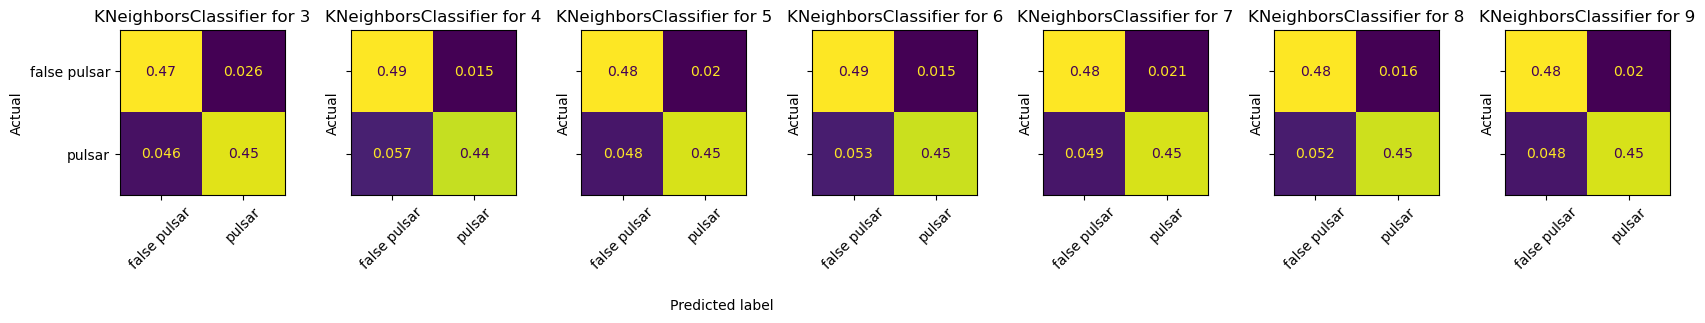

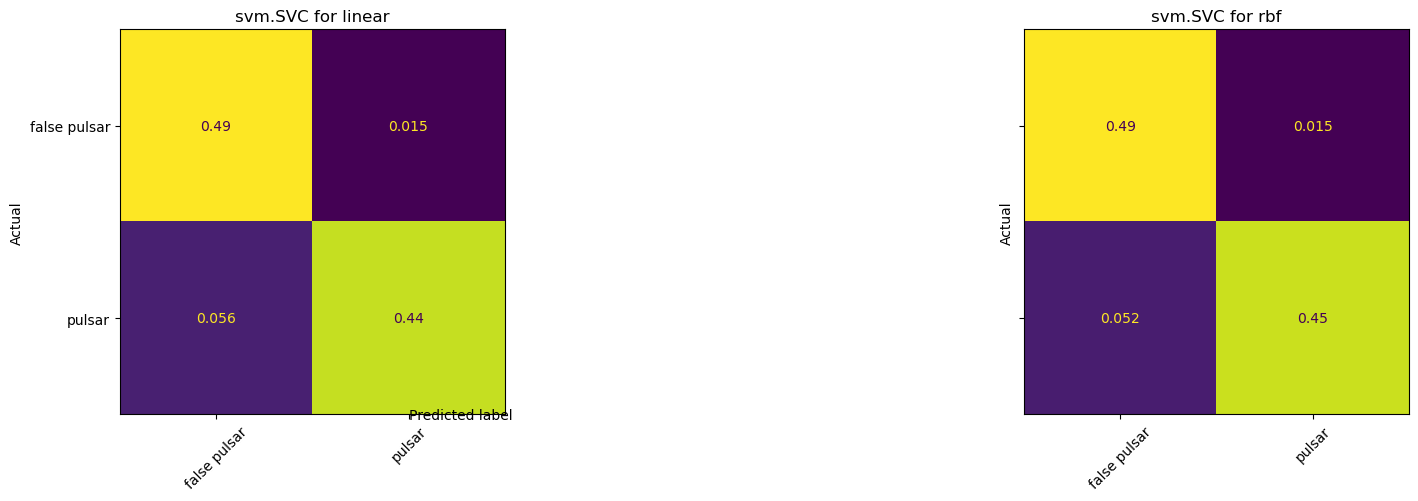

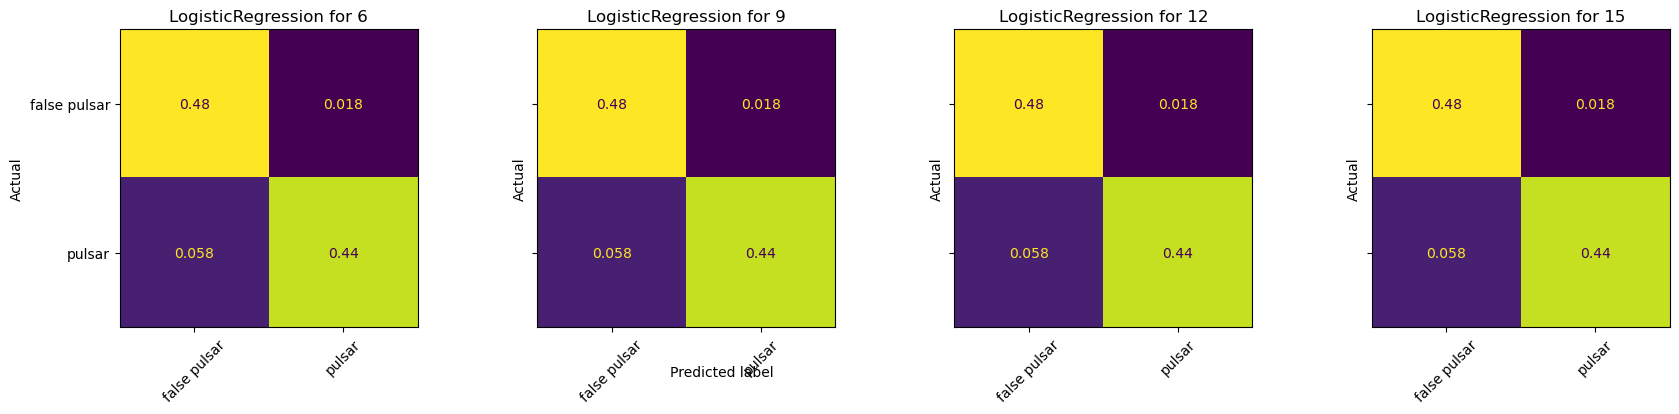

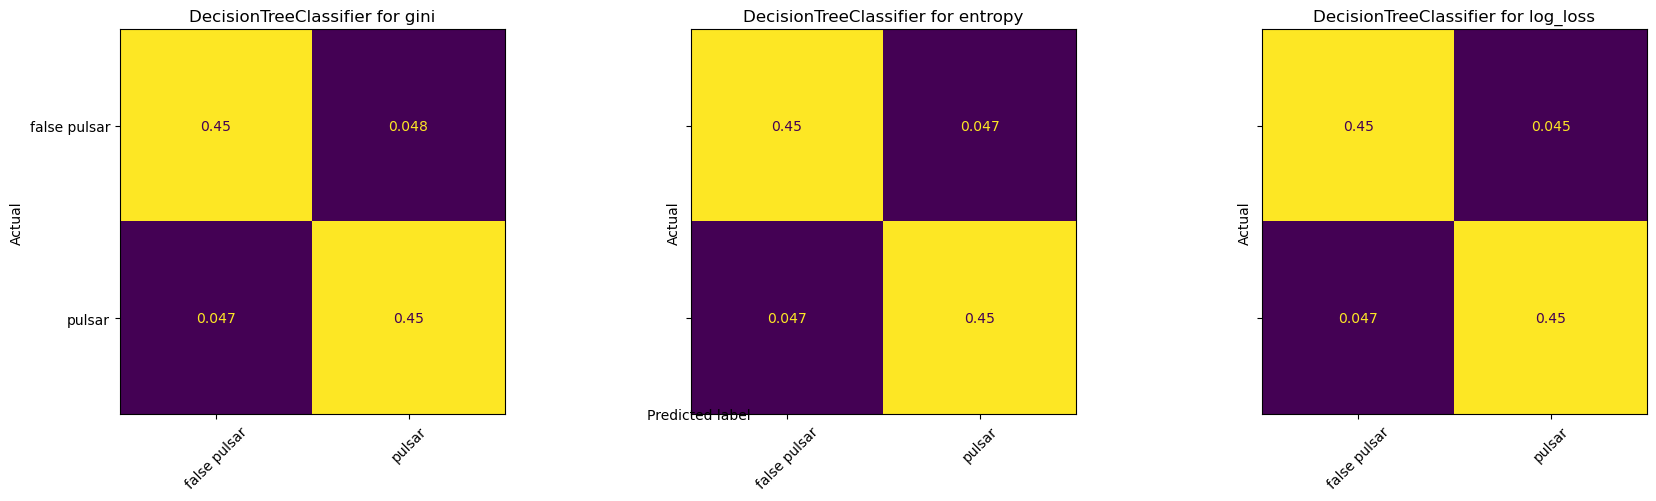

In [19]:
run_sampler_with_clasifier(df_0,RandomUnderSampler(random_state=0), classifiers, classifiers_names, parameters, False)

### Performance on an Unbalanced Test Set:

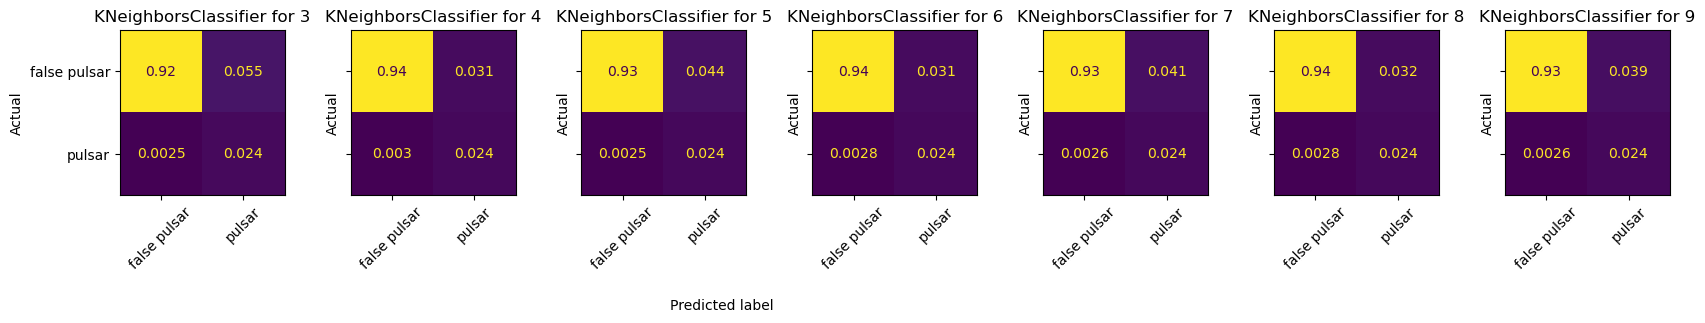

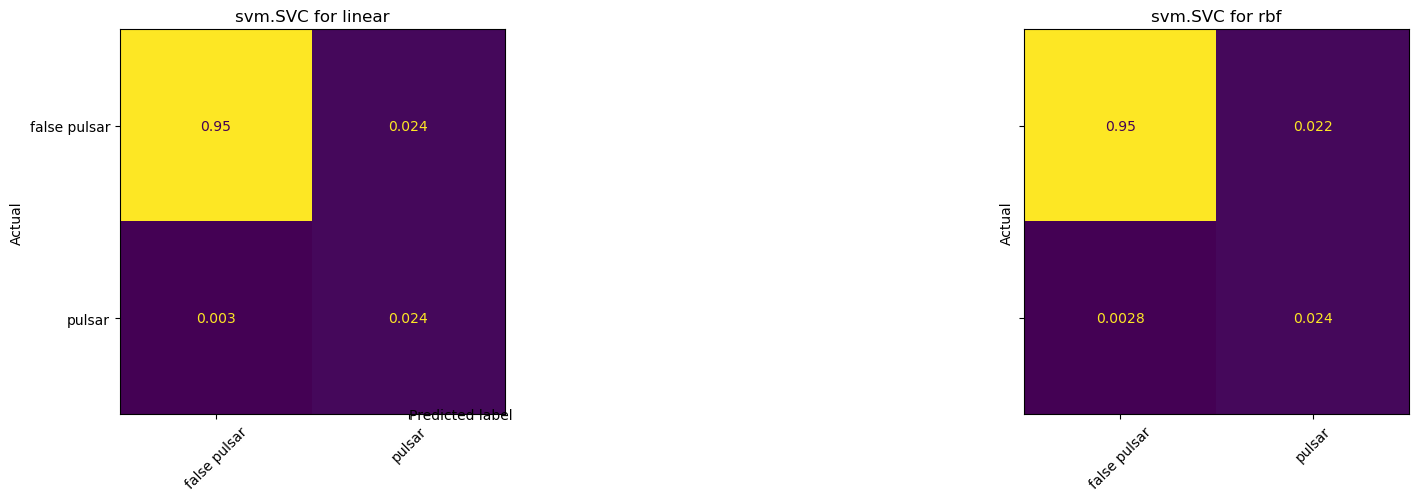

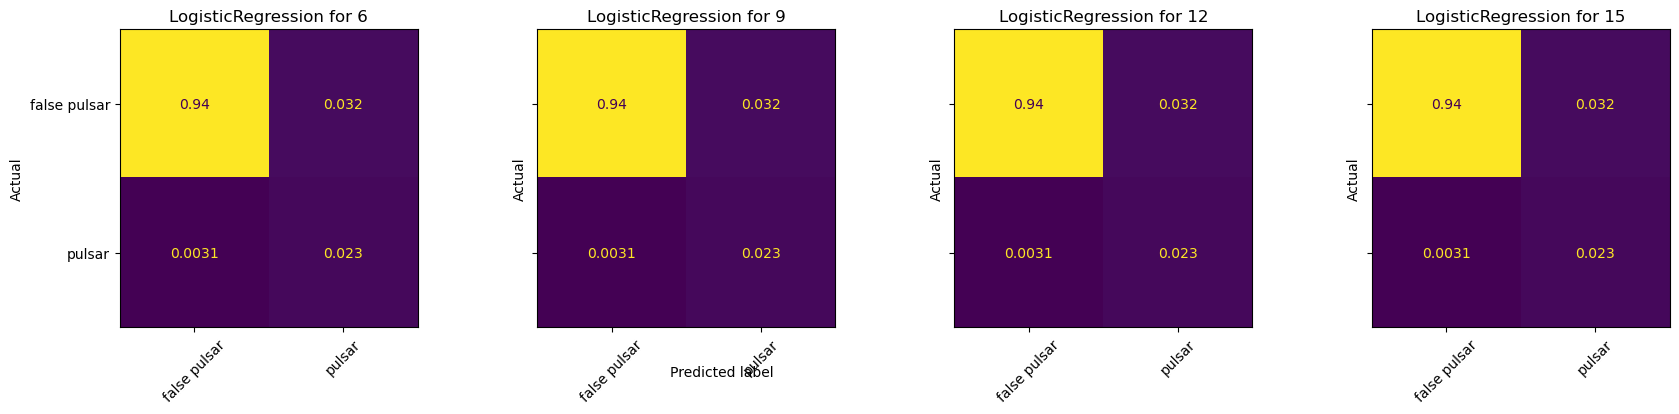

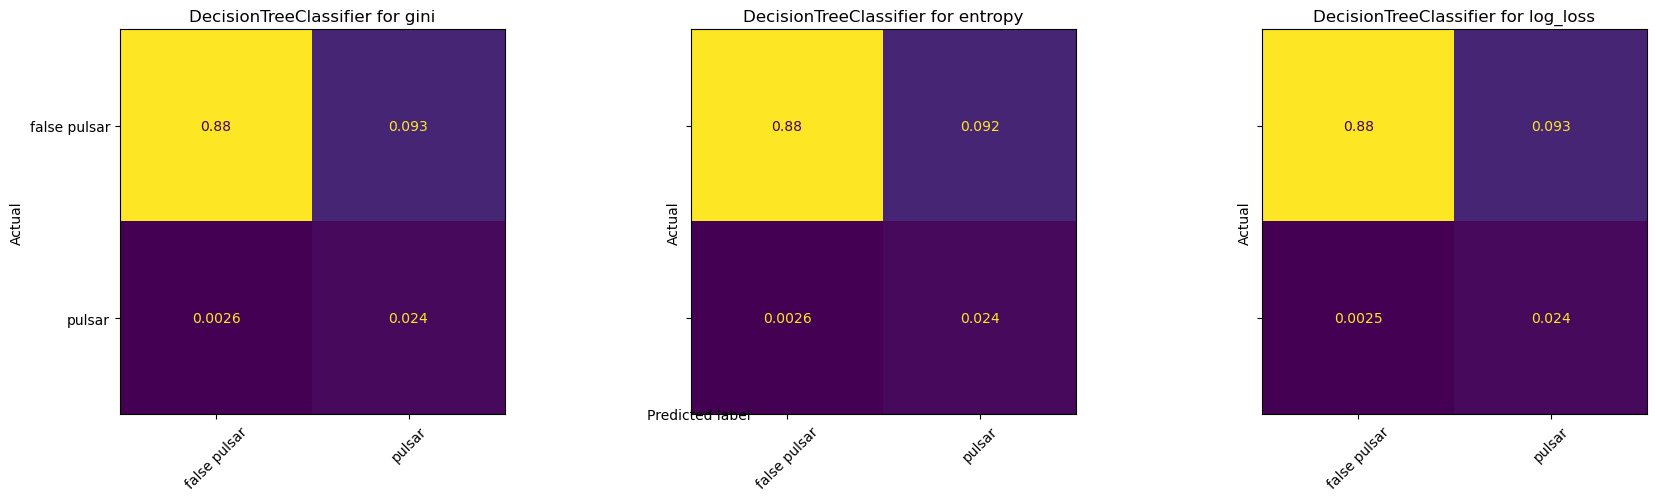

In [20]:
run_sampler_with_clasifier(df_0,RandomUnderSampler(random_state=0), classifiers, classifiers_names, parameters, True)

### Performance with the Reduced Dataset on an Unbalanced Test Set:

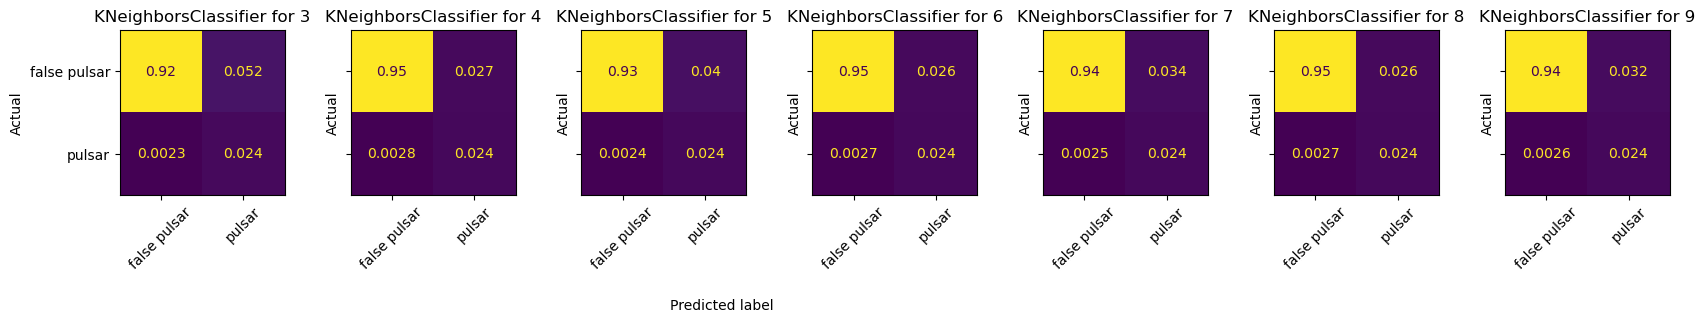

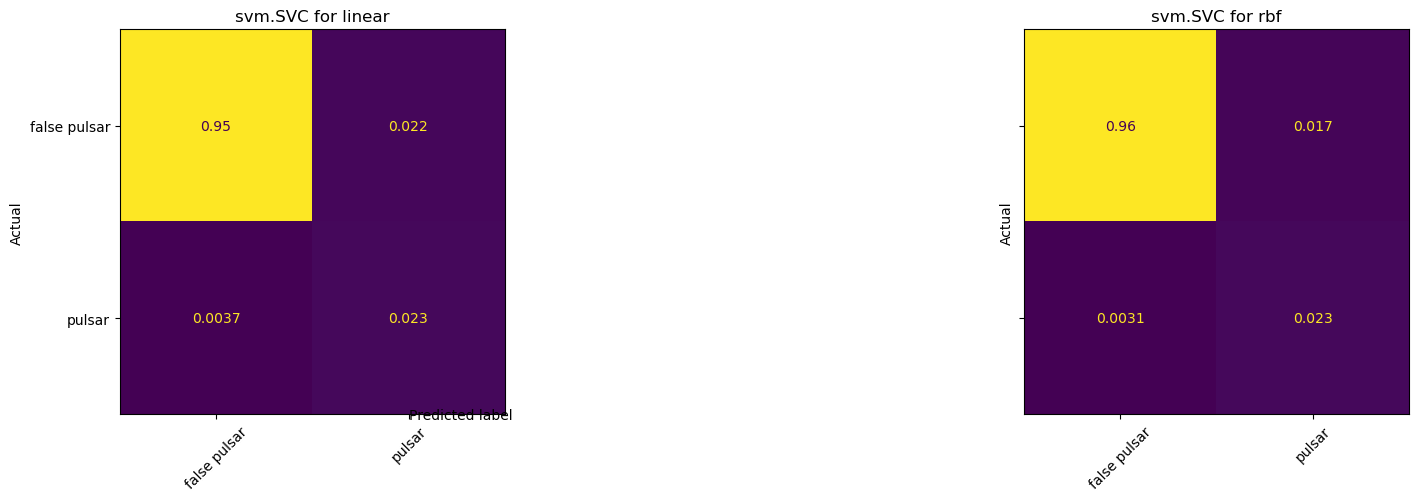

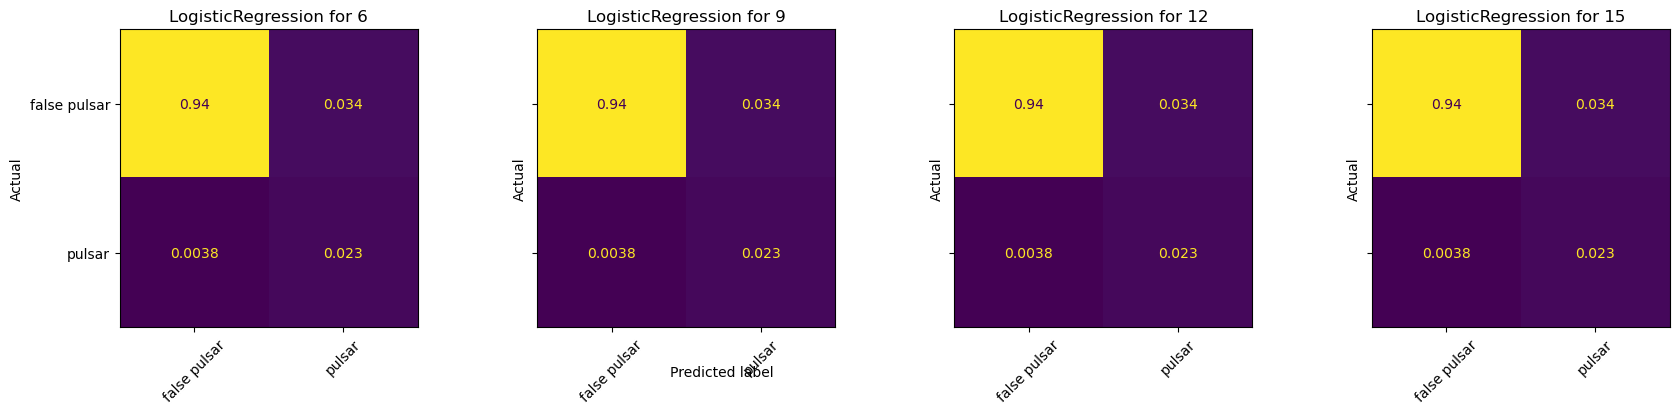

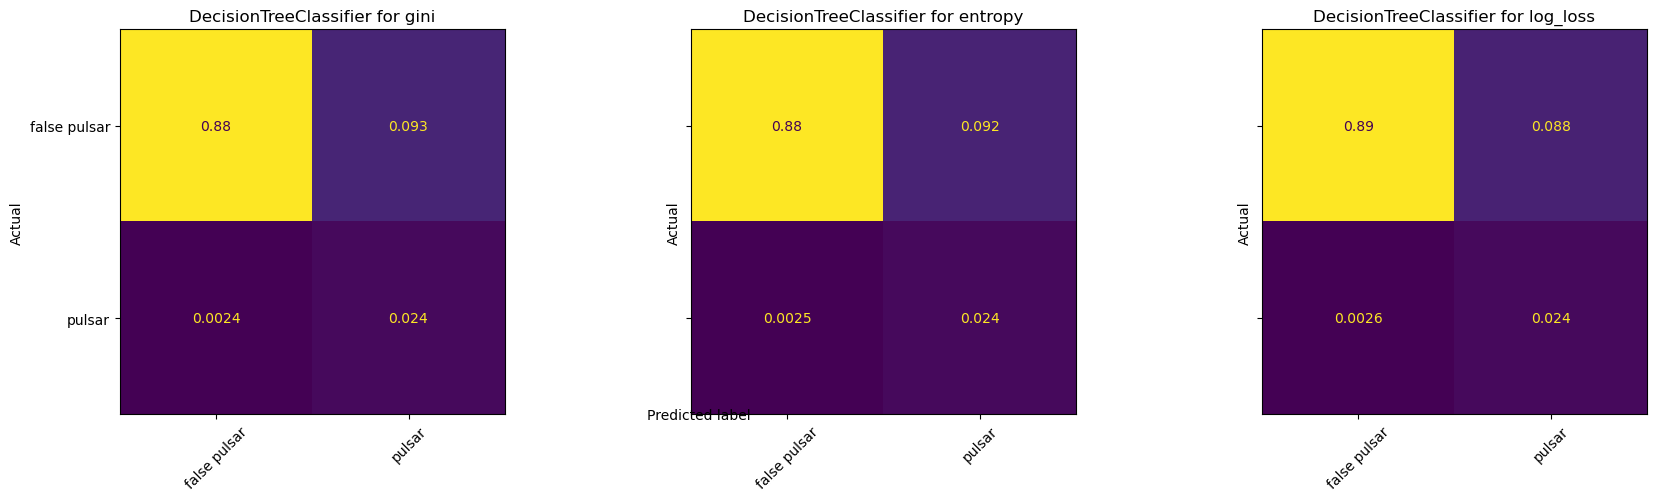

In [22]:
run_sampler_with_clasifier(df_c,RandomUnderSampler(random_state=0), classifiers, classifiers_names, parameters, True)

# NeighbourhoodCleaningRule(n_neighbors=4)

Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x00000177018E9D00>
Traceback (most recent call last):
  File "C:\Users\ethne\anaconda3\Lib\weakref.py", line 60, in _cb
    callback(self)
  File "C:\Users\ethne\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py", line 259, in _remove_proxy
    del self.callbacks[signal][cid]
        ~~~~~~~~~~~~~~^^^^^^^^
KeyError: 'changed'


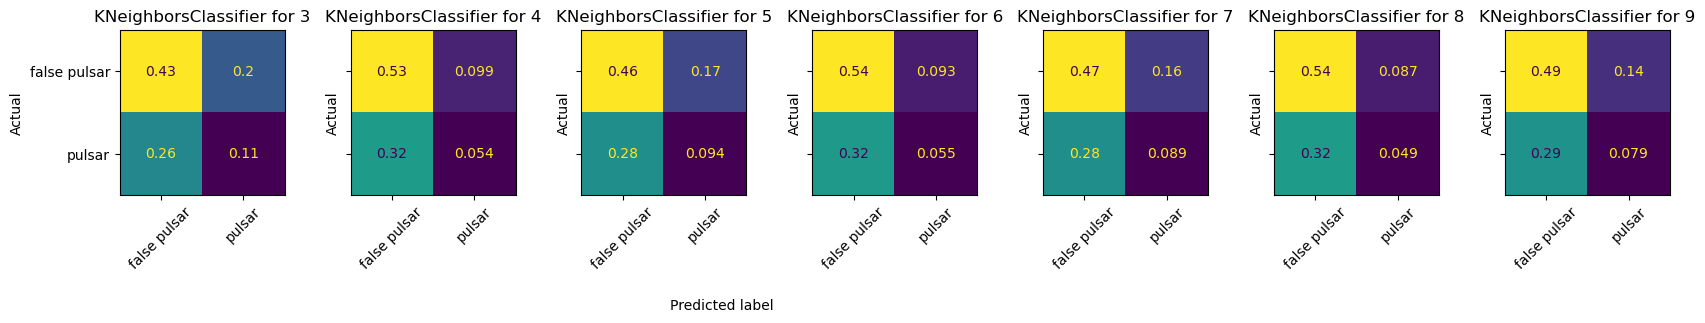

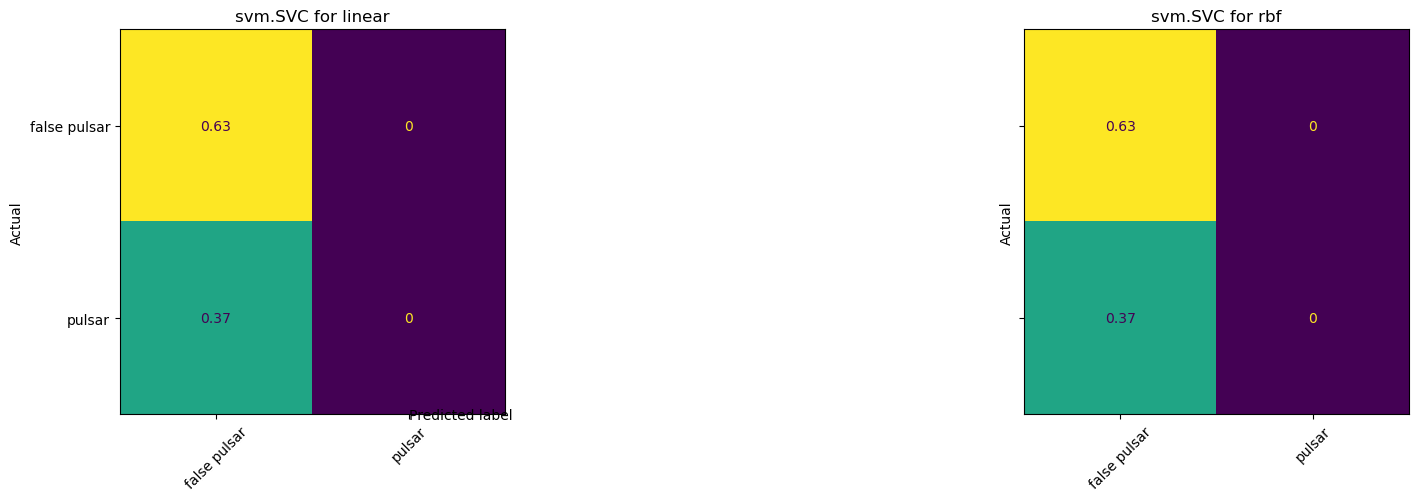

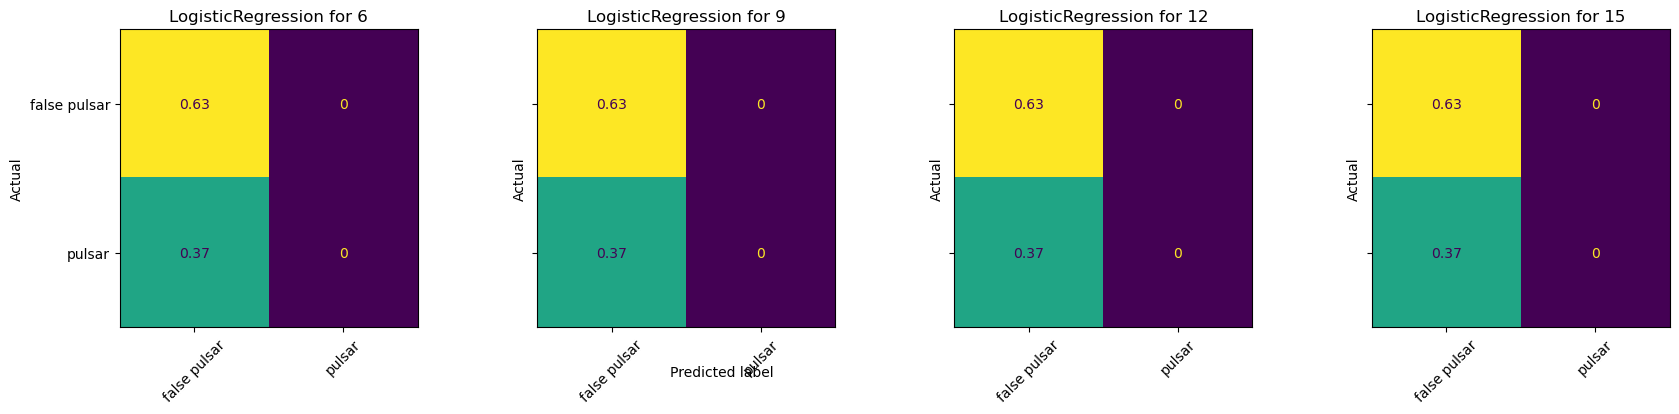

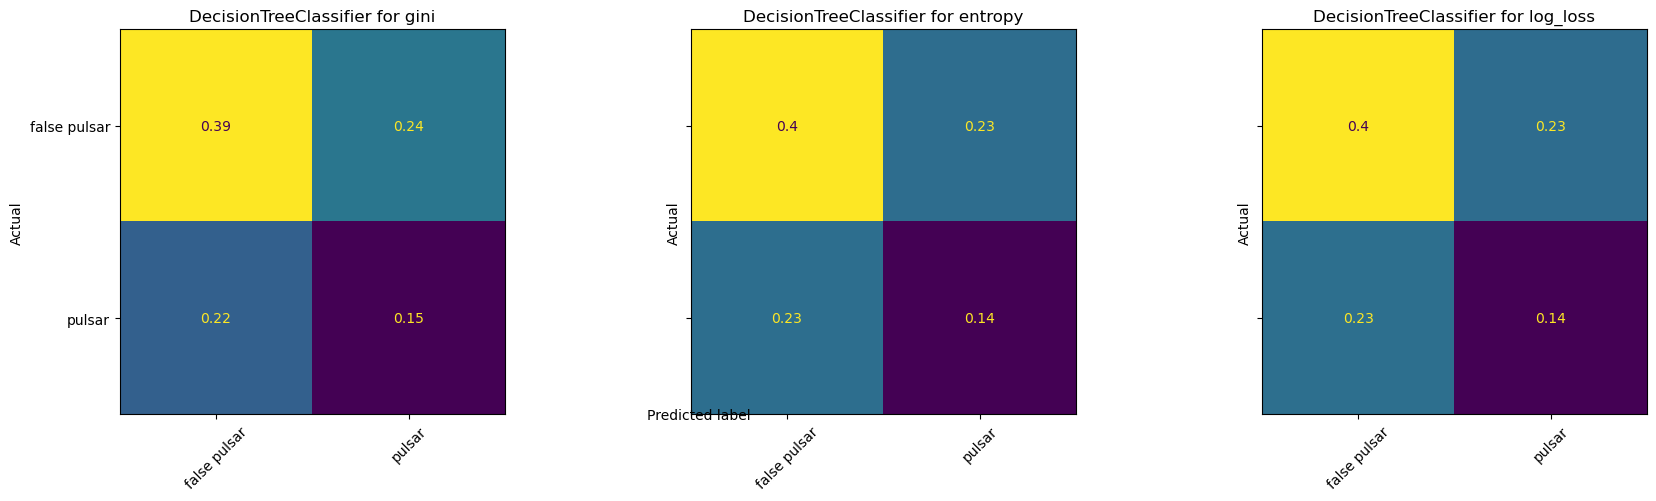

In [20]:
run_sampler_with_clasifier(df_0,NeighbourhoodCleaningRule(n_neighbors=4), classifiers, classifiers_names, parameters, False)

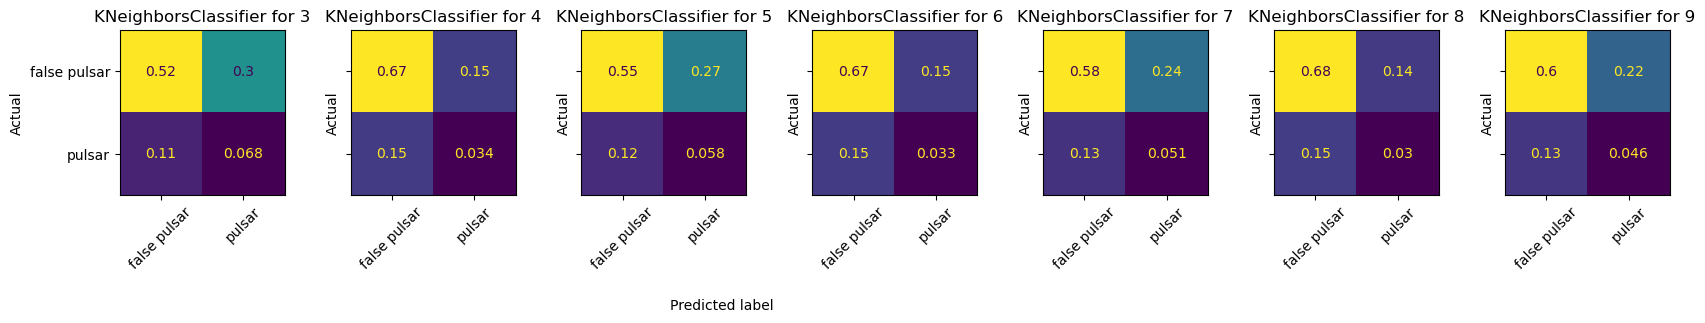

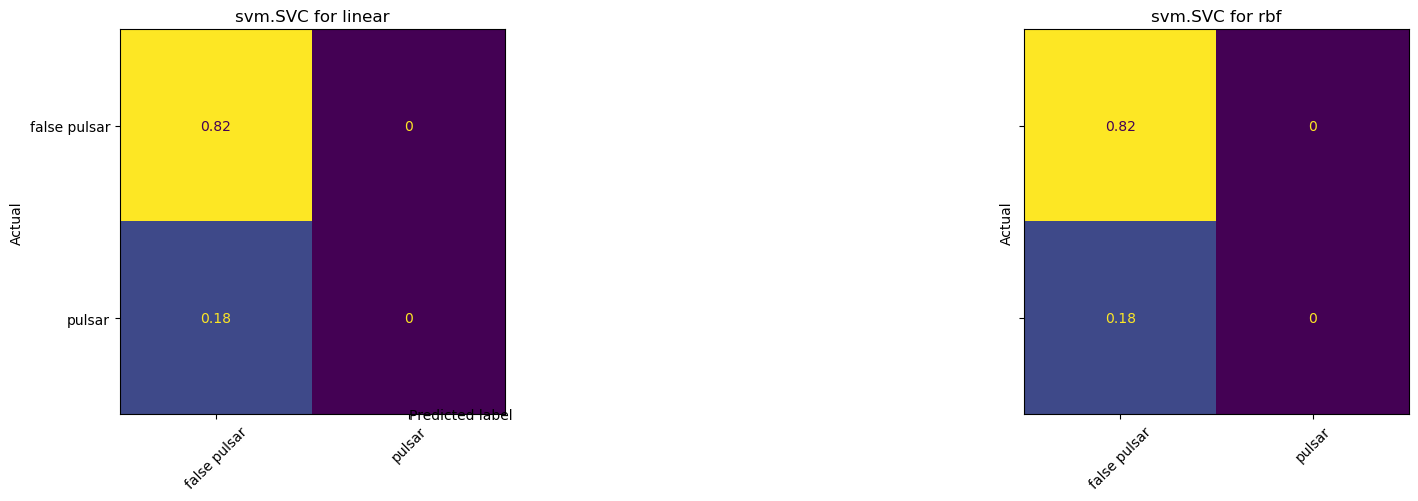

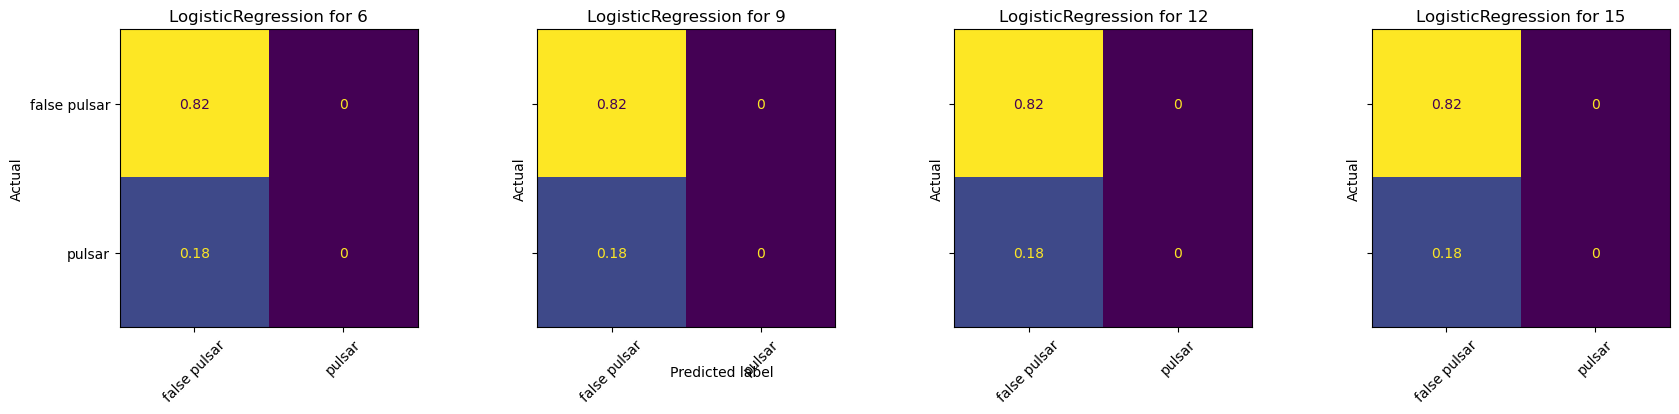

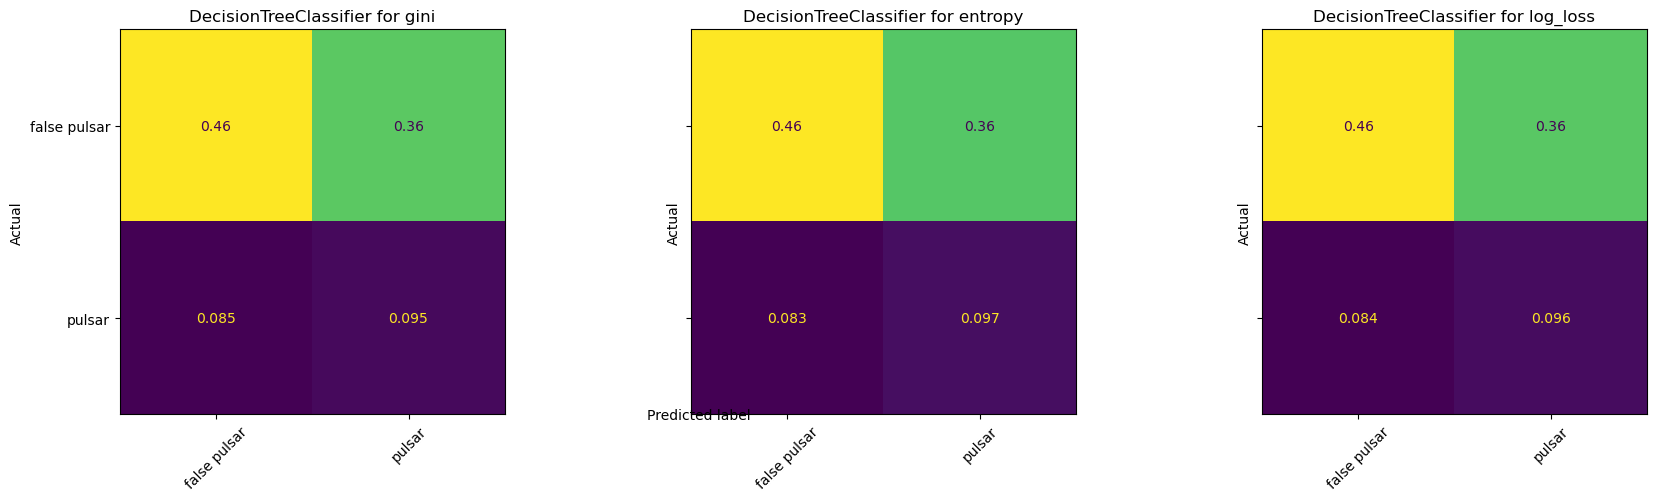

In [21]:
run_sampler_with_clasifier(df_c,NeighbourhoodCleaningRule(n_neighbors=4), classifiers, classifiers_names, parameters, True)

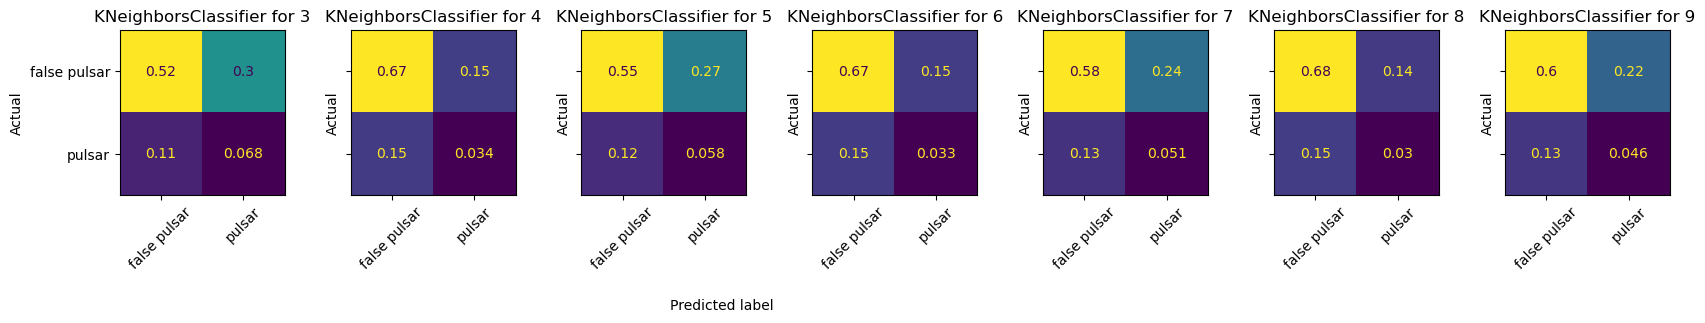

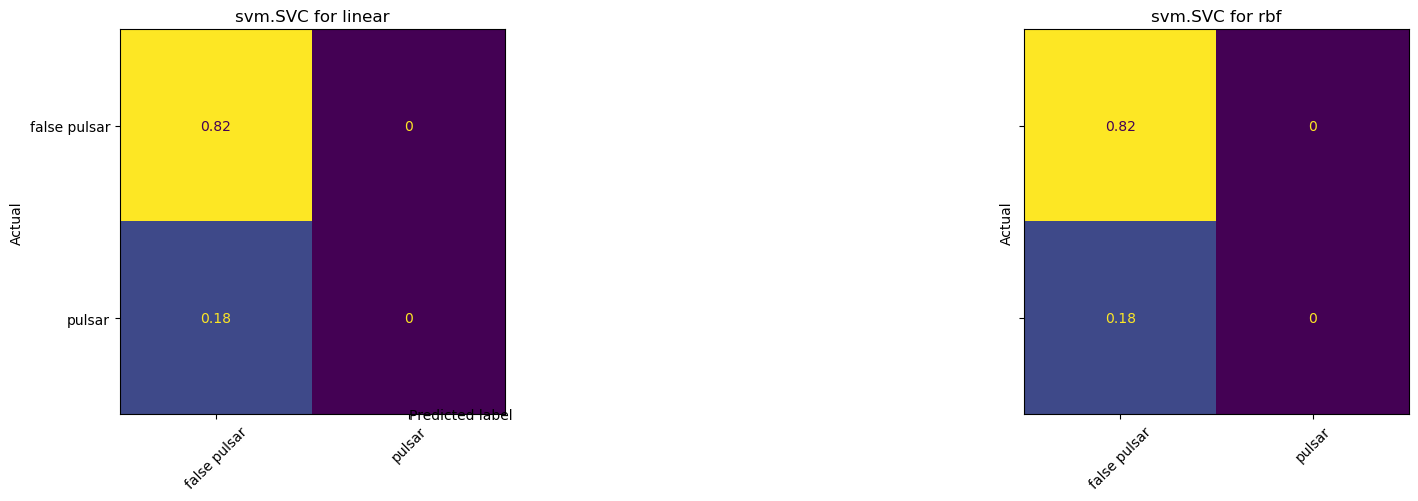

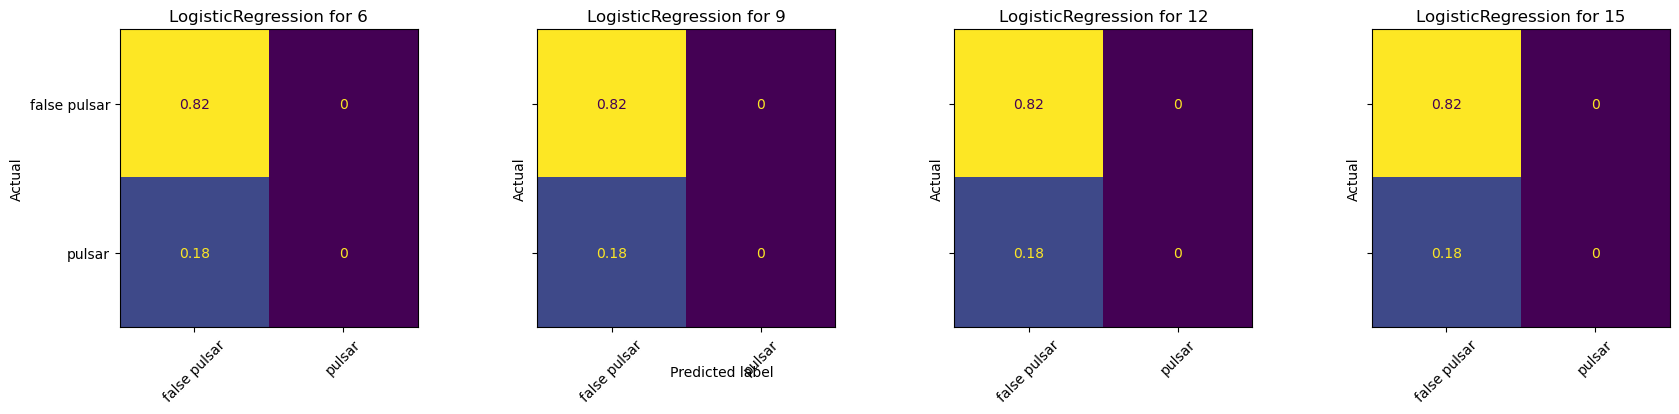

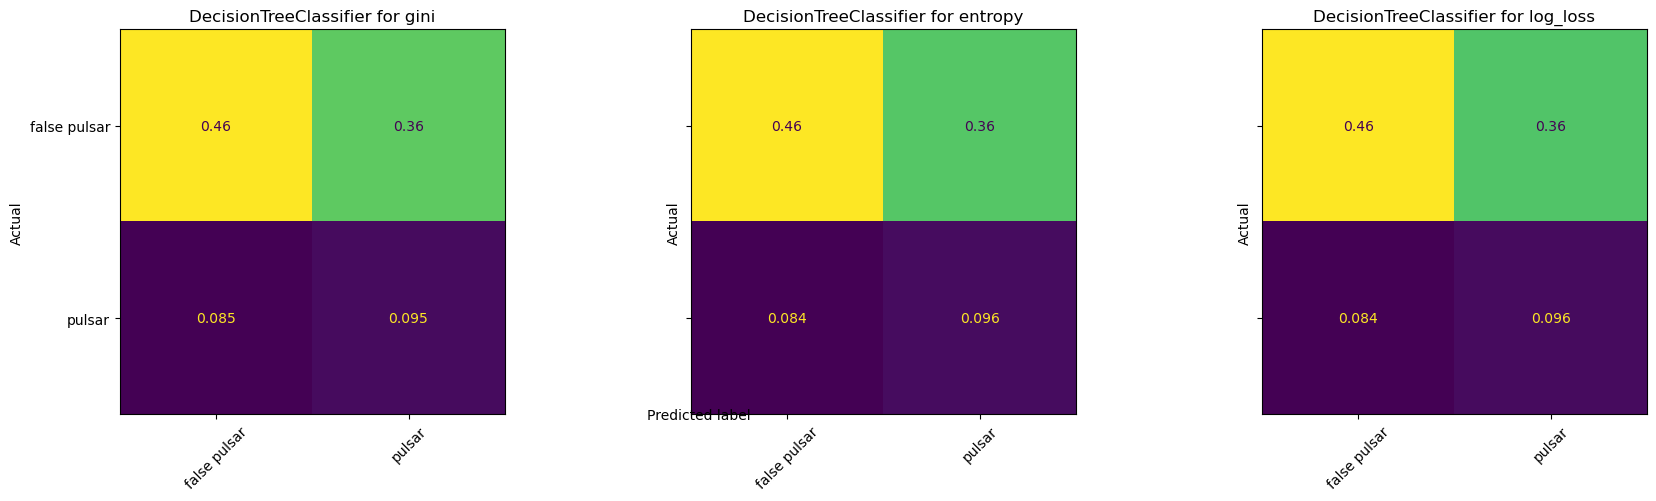

In [22]:
run_sampler_with_clasifier(df_c,NeighbourhoodCleaningRule(n_neighbors=4), classifiers, classifiers_names, parameters, True)